In [1]:
import math
import json
from time import time
from random import shuffle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

### NN ARCHITECTURES

In [2]:
# Learn semantic relatedness between two feature vectors
class SemRelNN (nn.Module):
    def __init__(self, max_score=3):
        super(SemRelNN, self).__init__()
        self.classes = max_score + 1
        self.dense = nn.Linear(1, self.classes, bias=True)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, ins1, ins2):
        inputs = ins1 * ins2
        inputs = inputs.sum(axis=1)
        inputs = inputs.reshape((-1, 1))
        logits = self.dense(inputs)
        dist = self.soft(logits)
        return dist


In [3]:
# Transfer learning from the pre-trained models
class FineTuneNN (nn.Module):
    def __init__(self, input_dim, output_dim=512, act=torch.tanh):
        super(FineTuneNN, self).__init__()
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.dense1 = nn.Linear(input_dim, output_dim, bias=True)
        self.dense2 = nn.Linear(output_dim, output_dim, bias=True)
        self.act_fn = act

    def forward(self, inputs):
        out1 = self.dense1(inputs)
        act_out1 = self.act_fn(out1)
        out2 = self.dense2(act_out1)
        act_out2 = self.act_fn(out2)
        return act_out2


In [4]:
class QBESciAR (nn.Module):
    def __init__(self, baseline, facet, input_dim, max_score=3, act=torch.tanh):
        super(QBESciAR, self).__init__()
        self.baseline = baseline
        self.facet = facet
        self.fine_tuner = FineTuneNN(input_dim, input_dim, act)
        self.score_gen = SemRelNN(max_score)
        self.train_acc_step = []
        self.train_acc_epoch = []
        self.train_loss_step = []
        self.train_loss_epoch = []
        self.valid_acc = []
        self.valid_loss = []

    def forward(self, ins1, ins2):
        tuned1 = self.fine_tuner(ins1)
        tuned2 = self.fine_tuner(ins2)
        return self.score_gen(tuned1, tuned2)


### DATASET UTILITES

In [5]:
def ResampleDataset(dataset):
    sm = SMOTE(random_state=42)
    dim = len(dataset[0][0])

    X = np.array([s[0] + s[1] for s in dataset])
    Y = np.array([s[2] for s in dataset])
    X, Y = sm.fit_resample(X, Y)

    l = Y.shape[0]
    data = [(X[i][:dim], X[i][dim:], Y[i]) for i in range(l)]
    return data


In [6]:
def PrepareDataset(baseline, facet):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)

    query_feature_data_file_name = 'data/' + baseline + '/' + facet + '.json'
    query_feature_data_file = open(query_feature_data_file_name)
    query_feature_data = json.load(query_feature_data_file)

    cand_feature_data_file_name = 'data/' + baseline + '/all.json'
    cand_feature_data_file = open(cand_feature_data_file_name)
    cand_feature_data = json.load(cand_feature_data_file)

    data = []
    for q in rank_data.keys():
        qvec = query_feature_data[q]
        l = len(rank_data[q]['cands'])
        for i in range(l):
            cand = rank_data[q]['cands'][i]
            score = rank_data[q]['relevance_adju'][i]
            data.append((qvec, cand_feature_data[cand], score))

    rank_data_file.close()
    query_feature_data_file.close()
    cand_feature_data_file.close()

    data = ResampleDataset(data)
    return data


In [7]:
def ReFormatAbstractData():
    abstract_data = dict()
    with open('data/abstracts-csfcube-preds.jsonl', 'r') as abstract_file:
        json_list = list(abstract_file)
    for json_str in json_list:
        line = json.loads(json_str)
        abstract_data[line['paper_id']] = line
    with open('data/abstracts-csfcube-preds.json', 'w') as formatted_abstract_file:
        json.dump(abstract_data, formatted_abstract_file)


In [8]:
# ReFormatAbstractData()

In [9]:
def SplitDataset(data, tr_v_te_ratio=[0.40, 0.15, 0.45]):
    tr_v_te_ratio = [_ / sum(tr_v_te_ratio) for _ in tr_v_te_ratio]
    tr_s = int(tr_v_te_ratio[0] * len(data))
    vl_s = int(tr_v_te_ratio[1] * len(data))
    te_s = len(data) - tr_s - vl_s

    shuffle(data)
    train_data = data[:tr_s]
    valid_data = data[tr_s:(tr_s+vl_s)]
    test_data = data[(tr_s+vl_s):]

    return train_data, valid_data, test_data


### TRAINING UTILITIES

In [10]:
def MakeBatches(dataset, batch_size=16):
    shuffle(dataset)
    batches = list()
    for start in range(0, len(dataset), batch_size):
        end = start + batch_size
        ins1, ins2, outs = list(zip(*dataset[start:end]))
        ins1, ins2, outs = torch.tensor(ins1).float(), torch.tensor(
            ins2).float(), torch.tensor(outs)
        batches.append((ins1, ins2, outs))
    return batches


In [11]:
def Train(train_data, val_data, baseline, facet,
          epochs=500, lr=0.01, batch_size=16,
          early_stopping_tolerance=4,
          desirable_train_acc=0.95):

    input_dim = len(train_data[0][0])
    MODEL = QBESciAR(baseline, facet, input_dim, max_score=3)

    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(MODEL.parameters(), lr=lr)
    consec_inc = 0
    prev_valid_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0.0
        batches = MakeBatches(train_data, batch_size)
        epoch_start_time = time()
        correct_preds = 0
        total_samples = 0

        for step, (ins1, ins2, true) in enumerate(batches):
            pred = MODEL(ins1, ins2)
            pred_labels = torch.argmax(pred, dim=1)

            loss = loss_fn(pred, true)

            total_loss += loss
            c = (pred_labels == true).sum()
            correct_preds += c
            total_samples += true.shape[0]

            MODEL.train_loss_step.append(loss)
            MODEL.train_acc_step.append(c / true.shape[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = total_loss / len(batches)
        acc = correct_preds / total_samples
        ti = time() - epoch_start_time

        val_acc, val_loss = AccLoss(val_data, loss_fn, MODEL)

        MODEL.train_acc_epoch.append(acc)
        MODEL.train_loss_epoch.append(mean_loss)
        MODEL.valid_acc.append(val_acc)
        MODEL.valid_loss.append(val_loss)

        logg = ' EPOCH {:3d} | T.LOSS : {:2.6f} | T.ACC : {:3f} | V.LOSS : {:.6f} | V.ACC : {:3f} | DUR : {:.4f}'
        print(logg.format(epoch+1, mean_loss, acc, val_loss, val_acc, ti))

        if (acc >= desirable_train_acc):
            print('\n [ EARLY STOPPING : DESIRABLE TRAINING ACCURACY REACHED ! ]')
            break

        if (prev_valid_loss < val_loss):
            consec_inc += 1
        else:
            consec_inc = 0
        prev_valid_loss = val_loss

        if (consec_inc == early_stopping_tolerance):
            print('\n [ EARLY STOPPING : VALIDATION LOSS NOT DECREASING ! ]')
            break

    MODEL.eval()
    model_name = baseline + '/' + facet + '.qbe'
    torch.save(MODEL, 'models-NLLLoss/' + model_name)
    return MODEL


### PLOT UTILITIES

In [12]:
def GetContingencyMatrix(true, pred):
    mat = np.zeros((4, 4))
    l = len(true)
    for i in range(l):
        mat[pred[i]][true[i]] += 1
    return mat


In [13]:
def PlotAndSaveContingencyMatrix(true, pred, loc):
    contingency_mat = GetContingencyMatrix(true, pred)
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(contingency_mat)
    ax.set_xlabel('TRUE SCORES', fontsize=13)
    ax.set_ylabel('PREDICTED SCORES', fontsize=13)
    plt.show()
    fig.savefig(loc)


In [14]:
def PlotAccuracyProgress(train_step_hist, train_epoch_hist, valid_hist, loc):
    steps = len(train_step_hist)
    epochs = len(train_epoch_hist)
    r = steps / epochs

    xe = np.array(range(epochs)) * r
    xs = np.array(range(steps))

    fontsize = 12
    plt.style.use('seaborn-whitegrid')
    currentAxis = plt.gca()
    currentAxis.plot(xe, train_epoch_hist, linewidth=2.5)
    currentAxis.plot(xe, valid_hist, linewidth=1.8)
    currentAxis.plot(xs, train_step_hist, linewidth=1, color='C3', alpha=0.5)

    plt.legend(["TRAIN-SET (epoch-wise)", "VALID-SET (epoch-wise)",
                "TRAIN-SET (step-wise)"], loc="lower right")

    plt.xlabel('STEP / EPOCH', fontsize=fontsize)
    plt.ylabel('ACCURACY', fontsize=fontsize)
    plt.title('PROGRESS OF ACCURACY', fontsize=13, fontweight='bold')
    plt.savefig('plots-NLLLoss/' + loc)
    plt.show()


In [15]:
def PlotLossProgress(train_step_hist, train_epoch_hist, valid_hist, loc):
    steps = len(train_step_hist)
    epochs = len(train_epoch_hist)
    r = steps / epochs

    xe = np.array(range(epochs)) * r
    xs = np.array(range(steps))

    fontsize = 12
    plt.style.use('seaborn-whitegrid')
    currentAxis = plt.gca()
    currentAxis.plot(xe, train_epoch_hist, linewidth=2.5)
    currentAxis.plot(xe, valid_hist, linewidth=1.8)
    currentAxis.plot(xs, train_step_hist, linewidth=1, color='C3', alpha=0.5)

    plt.legend(["TRAIN-SET (epoch-wise)", "VALID-SET (epoch-wise)",
                "TRAIN-SET (step-wise)"], loc="upper right")

    plt.xlabel('STEP / EPOCH', fontsize=fontsize)
    plt.ylabel('LOSS', fontsize=fontsize)
    plt.title('PROGRESS OF LOSS', fontsize=13, fontweight='bold')
    plt.savefig('plots-NLLLoss/' + loc)
    plt.show()


### COGNITIVE EVALUATION

In [16]:
def GetQueryFeature(baseline, facet, paper_id):
    query_feature_data_file_name = 'data/' + baseline + '/' + facet + '.json'
    query_feature_data_file = open(query_feature_data_file_name)
    query_feature_data = json.load(query_feature_data_file)
    query_feature_data_file.close()
    return query_feature_data[paper_id]


def GetCandidateFeatures(baseline, facet, paper_id):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)

    cand_feature_data_file_name = 'data/' + baseline + '/all.json'
    cand_feature_data_file = open(cand_feature_data_file_name)
    cand_feature_data = json.load(cand_feature_data_file)

    rank_data_file.close()
    cand_feature_data_file.close()

    cand_features = [cand_feature_data[cand_pid]
                     for cand_pid in rank_data[paper_id]['cands']]
    return rank_data[paper_id]['cands'], cand_features


In [17]:
def QBERetrieveSciArticles(baseline, facet, paper_id, top=True, ret_k=15):
    qf = GetQueryFeature(baseline, facet, paper_id)
    cand_pids, cand_f = GetCandidateFeatures(baseline, facet, paper_id)
    cand_c = len(cand_f)

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    ins1, ins2 = [qf] * cand_c, cand_f
    ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

    pred = model(ins1, ins2)
    pred_labels = torch.argmax(pred, dim=1).numpy()
    pred = pred.detach().numpy()
    rank_scores = [l + (l != 0) * pred[i][l] + (l == 0) * (1 - pred[i][0])
                   for i, l in enumerate(pred_labels)]

    scored_cands = list(zip(cand_pids, rank_scores))
    scored_cands.sort(key=lambda x: -1 * x[1])

    abstract_data_file = open('data/abstracts-csfcube-preds.json')
    abstract_data = json.load(abstract_data_file)
    abstract_data_file.close()

    results = None
    if top:
        results = scored_cands[:ret_k]
    else:
        results = scored_cands[-ret_k:]
        results.reverse()

    print('\n >>> BASELINE : ' + baseline + ' <<<')
    print(' >>> FACET : ' + facet + ' <<<')

    print('\n +++ QUERY PAPER +++\n')
    print(' [ TITLE ] ' + abstract_data[paper_id]['title'])
    print(' [ ABSTRACT ] ')
    for sent in abstract_data[paper_id]['abstract']:
        print('', sent)

    if top:
        print('\n +++ TOP {} PAPERS +++\n'.format(ret_k))
    else:
        print('\n +++ BOTTOM {} PAPERS +++\n'.format(ret_k))

    for rank, (pid, score) in enumerate(results):
        print(' RANK : {} | PAPER I.D. : {} | GRADED RELEVANCE SCORE : {:.4f}'.format(
            rank+1, pid, score))
        print(' [ TITLE ] ' + abstract_data[pid]['title'])
        print(' [ ABSTRACT ] ')
        for sent in abstract_data[pid]['abstract']:
            print('', sent)
        print('\n')


### ANALYTICAL EVALUATION

In [18]:
def AccLoss(data, loss_fn, MODEL):
    batches = MakeBatches(data)
    total_loss = 0
    correct_preds = 0
    total_samples = 0

    for __, (ins1, ins2, true) in enumerate(batches):
        pred = MODEL(ins1, ins2)
        pred_labels = torch.argmax(pred, dim=1)

        loss = loss_fn(pred, true)

        total_loss += loss.item()
        correct_preds += (pred_labels == true).sum()
        total_samples += true.shape[0]

    mean_loss = total_loss / len(batches)
    acc = correct_preds / total_samples
    return acc, mean_loss


def Pred(data, MODEL):
    preds = []

    for in1, in2, __ in data:
        in1 = in1.reshape((1, -1))
        in2 = in2.reshape((1, -1))
        in1, in2 = torch.tensor(in1).float(), torch.tensor(in2).float()
        pred = MODEL(in1, in2)
        pred_label = torch.argmax(pred, dim=1)
        preds.append(pred_label.item())

    return preds


In [19]:
def GetMSE(x, y):
    x, y = np.array(x), np.array(y)
    return ((x - y) ** 2).mean()


In [20]:
def DCG(rank_scores, K=100):
    score = rank_scores[0]
    l = int(len(rank_scores) * (K/100))
    for i in range(1, l):
        score += rank_scores[i] / math.log2(i + 1)
    return score


def NDCG(pred_scores, ideal_scores, K=100):
    return DCG(pred_scores, K) / DCG(ideal_scores, K)


def AllNDCG(baseline, facet, K=100):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    all_ndcg = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)
        ideal_ranking_scores = true_labels
        ideal_ranking_scores.sort(reverse=True)

        ndcg = NDCG(pred_ranking_scores, ideal_ranking_scores, K)
        all_ndcg.append(ndcg)

    return np.array(all_ndcg)


In [21]:
def PrecisionAtK(pred_ranking_scores, K):
    pred_ranking_scores = pred_ranking_scores[:K]
    K = len(pred_ranking_scores)
    return len([_ for _ in pred_ranking_scores if _ > 1]) / K


def MeanPrecisionAtK(baseline, facet, K=20, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        prec_at_k = PrecisionAtK(pred_ranking_scores, K)
        values.append(prec_at_k)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [22]:
def RecallAtK(pred_ranking_scores, K):
    tot = len([_ for _ in pred_ranking_scores if _ > 1])
    pred_ranking_scores = pred_ranking_scores[:K]
    return len([_ for _ in pred_ranking_scores if _ > 1]) / tot


def MeanRecallAtK(baseline, facet, K=20, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        recall_at_k = RecallAtK(pred_ranking_scores, K)
        values.append(recall_at_k)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [23]:
def AveragePrecision(pred_ranking_scores):
    precs = []
    count = 0
    for it, rel in enumerate(pred_ranking_scores):
        if (rel == 1):
            continue
        count += 1
        precs.append(count / (it + 1))
    return sum(precs) / len(precs)


def MeanAveragePrecision(baseline, facet, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        avg_prec = AveragePrecision(pred_ranking_scores)
        values.append(avg_prec)

    if (not need_list):
        return sum(values) / len(values)
    return values


In [24]:
def RPrecision(pred_ranking_scores):
    tot = len([_ for _ in pred_ranking_scores if _ > 1])
    pred_ranking_scores = pred_ranking_scores[:tot]
    return len([_ for _ in pred_ranking_scores if _ > 1]) / tot


def MeanRPrecision(baseline, facet, need_list=False):
    rank_data_file_name = 'data/test-pid2anns-csfcube-' + facet + '.json'
    rank_data_file = open(rank_data_file_name)
    rank_data = json.load(rank_data_file)
    rank_data_file.close()

    model_name = baseline + '/' + facet + '.qbe'
    model = torch.load('models-NLLLoss/' + model_name)
    model.eval()

    query_pids = rank_data.keys()
    values = []

    for pid in query_pids:
        true_labels = rank_data[pid]['relevance_adju']

        qf = GetQueryFeature(baseline, facet, pid)
        cand_pids, cand_f = GetCandidateFeatures(baseline, facet, pid)
        cand_c = len(cand_f)

        ins1, ins2 = [qf] * cand_c, cand_f
        ins1, ins2 = torch.tensor(ins1).float(), torch.tensor(ins2).float()

        pred = model(ins1, ins2)
        pred_labels = list(torch.argmax(pred, dim=1).numpy())

        pred_true = list(zip(pred_labels, true_labels))
        pred_true.sort(key=lambda x: -1 * x[0])

        __, pred_ranking_scores = zip(*pred_true)

        r_prec = RPrecision(pred_ranking_scores)
        values.append(r_prec)

    if (not need_list):
        return sum(values) / len(values)
    return values


### AGGREGATED EVALUATION

In [25]:
def AggregatedNDCG(baseline, K=100):
    facets = ['background', 'result', 'method']
    all_ndcgs = []
    for facet in facets:
        all_ndcgs = np.concatenate((all_ndcgs, AllNDCG(baseline, facet, K)))
    return all_ndcgs


In [26]:
def AggregatedMeanPrecisionAtK(baseline, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanPrecisionAtK(baseline, facet, K, True))
    return sum(values) / len(values)


def AggregatedMeanRecallAtK(baseline, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanRecallAtK(baseline, facet, K, True))
    return sum(values) / len(values)


def AggregatedMeanRPrecision(baseline):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanRPrecision(baseline, facet, True))
    return sum(values) / len(values)


def AggregatedMeanAveragePrecision(baseline):
    facets = ['background', 'result', 'method']
    values = []
    for facet in facets:
        values.extend(MeanAveragePrecision(baseline, facet, True))
    return sum(values) / len(values)


In [27]:
def EvaluateOnAllQueries(baseline):
    ndcg_all_queries = AggregatedNDCG(baseline)
    print(' > (AGG) MEAN NDCG (@100%) : {:.3f} %'.format(
        100 * ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@100%) : {:.3f} %'.format(100 * ndcg_all_queries.std()))
    
    ndcg_all_queries_20 = AggregatedNDCG(baseline, K=20)
    print(' > (AGG) MEAN NDCG (@20%) : {:.3f} %'.format(
        100 * ndcg_all_queries_20.mean()))
    print(' > (AGG) STD-DEV in NDCG (@20%) : {:.3f} %'.format(100 * ndcg_all_queries_20.std()))
    
    print(' > (AGG) MEAN PRECISION@20 : {:.2f} %'.format(
        100 * AggregatedMeanPrecisionAtK(baseline, K=20)))
    print(' > (AGG) MEAN RECALL@20 : {:.2f} %'.format(
        100 * AggregatedMeanRecallAtK(baseline, K=20)))
    print(' > (AGG) MEAN R PRECISION : {:.2f} %'.format(
        100 * AggregatedMeanRPrecision(baseline)))
    print(' > (AGG) MEAN AVG. PRECISION : {:.2f} %'.format(
        100 * AggregatedMeanAveragePrecision(baseline)))


### TESTING & EVALUATION UTILITIES

In [28]:
def EvaluateOnTestData01(test_data, model, baseline, facet):
    preds = Pred(test_data, model)
    true = list(list(zip(*test_data))[2])
    mat = GetContingencyMatrix(true, preds)

    print('\n +++ CONTINGENCY MATRIX +++')
    print(mat)

    loc = 'plots-NLLLoss/' + baseline + '/' + facet + '_conting_mat'
    PlotAndSaveContingencyMatrix(true, preds, loc)


In [29]:
def EvaluateOnTestData02(test_data, model):
    preds = Pred(test_data, model)
    true = list(list(zip(*test_data))[2])

    loss_fn = nn.NLLLoss()
    acc, loss = AccLoss(test_data, loss_fn, model)

    print(' > LOSS : {:.4f}'.format(loss))
    print(' > ACCURACY : {:.4f}'.format(acc.item()))
    print(' > MEAN SQUARED ERR : {:.4f}'.format(GetMSE(preds, true)))

In [30]:
def EvaluateOnAllFacetQueries(baseline, facet):
    print(' > MEAN PRECISION@20 : {:.2f} %'.format(
        100 * MeanPrecisionAtK(baseline, facet, K=20)))
    print(' > MEAN RECALL@20 : {:.2f} %'.format(
        100 * MeanRecallAtK(baseline, facet, K=20)))
    print(' > MEAN R PRECISION : {:.2f} %'.format(
        100 * MeanRPrecision(baseline, facet)))
    print(' > MEAN AVG. PRECISION : {:.2f} %'.format(
        100 * MeanAveragePrecision(baseline, facet)))


### IMPLEMENTATION (INDIVIDUAL)

In [31]:
def Implement(baseline, facet, train=False):
    data = PrepareDataset(baseline, facet)
    train_data, valid_data, test_data = SplitDataset(data)

    print('\n > BASELINE :', baseline)
    print(' > FACET :', facet)
    print('\n', end='')

    model = None
    if (train):
        model = Train(train_data, valid_data, baseline, facet, lr=0.001,
                      epochs=300, batch_size=16, early_stopping_tolerance=4)
    else:
        model_name = baseline + '/' + facet + '.qbe'
        model = torch.load('models-NLLLoss/' + model_name)

    print('\n', model.eval())

    PlotAccuracyProgress(model.train_acc_step, model.train_acc_epoch,
                         model.valid_acc, baseline + '/' + facet + '_acc')

    PlotLossProgress(model.train_loss_step, model.train_loss_epoch,
                     model.valid_loss, baseline + '/' + facet + '_loss')

    print('\n', end='')
    EvaluateOnTestData01(test_data, model, baseline, facet)

    print('\n', end='')
    EvaluateOnTestData02(test_data, model)

    print('\n', end='')
    EvaluateOnAllFacetQueries(baseline, facet)

    ndcg_all_queries = AllNDCG(baseline, facet)
    print('\n > MEAN NDCG (@100%) : {:5f}'.format(ndcg_all_queries.mean()))
    print(' > (STD) DEV in NDCG (@100%) : {:5f}'.format(ndcg_all_queries.std()))

    ndcg_all_queries_20 = AllNDCG(baseline, facet, K=20)
    print('\n > MEAN NDCG (@20%) : {:5f}'.format(ndcg_all_queries_20.mean()))
    print(' > (STD) DEV in NDCG (@20%) : {:5f}'.format(ndcg_all_queries_20.std()))


### IMPLEMENTATION (ENSEMBLE)

In [32]:
def EnsembleNDCG(baselines, K=100):
    facets = ['background', 'result', 'method']
    all_ndcgs = np.array([])
    for t, facet in enumerate(facets):
        all_ndcgs = np.concatenate((all_ndcgs, AllNDCG(baselines[t], facet, K)))
    return all_ndcgs


In [33]:
def EnsembleMeanPrecisionAtK(baselines, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanPrecisionAtK(baselines[t], facet, K, True))
    return sum(values) / len(values)


def EnsembleMeanRecallAtK(baselines, K=20):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanRecallAtK(baselines[t], facet, K, True))
    return sum(values) / len(values)


def EnsembleMeanRPrecision(baselines):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanRPrecision(baselines[t], facet, True))
    return sum(values) / len(values)


def EnsembleMeanAveragePrecision(baselines):
    facets = ['background', 'result', 'method']
    values = []
    for t, facet in enumerate(facets):
        values.extend(MeanAveragePrecision(baselines[t], facet, True))
    return sum(values) / len(values)


In [34]:
def EnsembleEvaluateOnAllQueries(baselines):
    ndcg_all_queries = EnsembleNDCG(baselines)
    print(' > (AGG) MEAN NDCG (@100%) : {:.2f} %'.format(100*ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@100%) : {:.2f} %'.format(100*ndcg_all_queries.std()))
    ndcg_all_queries = EnsembleNDCG(baselines, K=20)
    print(' > (AGG) MEAN NDCG (@20%) : {:.2f} %'.format(100*ndcg_all_queries.mean()))
    print(
        ' > (AGG) STD-DEV in NDCG (@20%) : {:.2f} %'.format(100*ndcg_all_queries.std()))
    print(' > (AGG) MEAN PRECISION@20 : {:.2f} %'.format(
        100*EnsembleMeanPrecisionAtK(baselines, K=20)))
    print(' > (AGG) MEAN RECALL@20 : {:.2f} %'.format(
        100*EnsembleMeanRecallAtK(baselines, K=20)))
    print(' > (AGG) MEAN R PRECISION : {:.2f} %'.format(
        100*EnsembleMeanRPrecision(baselines)))
    print(' > (AGG) MEAN AVG. PRECISION : {:.2f} %'.format(
        100*EnsembleMeanAveragePrecision(baselines)))


## BERT-based NLI Baseline (bert_nli)

### [ BACKGROUND ]


 > BASELINE : bert_nli
 > FACET : background

 EPOCH   1 | T.LOSS : 2.611299 | T.ACC : 0.349854 | V.LOSS : 1.946981 | V.ACC : 0.332815 | DUR : 1.1022
 EPOCH   2 | T.LOSS : 1.853342 | T.ACC : 0.430904 | V.LOSS : 1.552752 | V.ACC : 0.486781 | DUR : 1.0942
 EPOCH   3 | T.LOSS : 1.499143 | T.ACC : 0.479883 | V.LOSS : 1.412947 | V.ACC : 0.541213 | DUR : 1.0934
 EPOCH   4 | T.LOSS : 1.243629 | T.ACC : 0.531778 | V.LOSS : 1.250198 | V.ACC : 0.547434 | DUR : 1.1267
 EPOCH   5 | T.LOSS : 1.269614 | T.ACC : 0.538192 | V.LOSS : 1.472301 | V.ACC : 0.533437 | DUR : 1.1529
 EPOCH   6 | T.LOSS : 0.984949 | T.ACC : 0.597085 | V.LOSS : 1.121550 | V.ACC : 0.592535 | DUR : 1.1003
 EPOCH   7 | T.LOSS : 0.767391 | T.ACC : 0.661808 | V.LOSS : 1.049281 | V.ACC : 0.623639 | DUR : 1.1257
 EPOCH   8 | T.LOSS : 0.691914 | T.ACC : 0.685714 | V.LOSS : 0.999034 | V.ACC : 0.664075 | DUR : 1.1638
 EPOCH   9 | T.LOSS : 0.644260 | T.ACC : 0.709038 | V.LOSS : 1.024661 | V.ACC : 0.618974 | DUR : 1.2282
 EPOCH  10 | T.LO

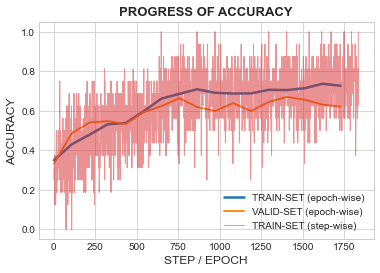

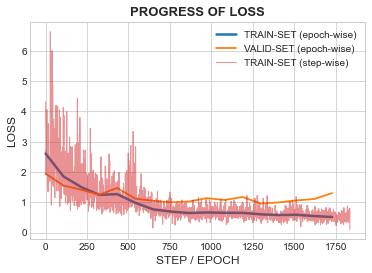



 +++ CONTINGENCY MATRIX +++
[[237.  72.   6.   0.]
 [  4.  18.  14.   0.]
 [207. 325. 371.   0.]
 [ 25.  96.  76. 479.]]


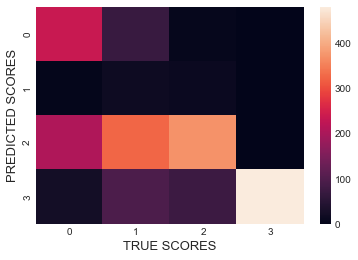


 > LOSS : 1.2966
 > ACCURACY : 0.5725
 > MEAN SQUARED ERR : 1.0114

 > MEAN PRECISION@20 : 26.56 %
 > MEAN RECALL@20 : 43.05 %
 > MEAN R PRECISION : 31.07 %
 > MEAN AVG. PRECISION : 59.74 %

 > MEAN NDCG (@100%) : 0.823851
 > (STD) DEV in NDCG (@100%) : 0.067795

 > MEAN NDCG (@20%) : 0.657926
 > (STD) DEV in NDCG (@20%) : 0.076558


In [37]:
baseline = 'bert_nli'
facet = 'background'
Implement(baseline, facet, train=True)


In [38]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : bert_nli <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using

### [ METHOD ]


 > BASELINE : bert_nli
 > FACET : method

 EPOCH   1 | T.LOSS : 2.902693 | T.ACC : 0.426820 | V.LOSS : 2.842665 | V.ACC : 0.436075 | DUR : 1.7267
 EPOCH   2 | T.LOSS : 2.497444 | T.ACC : 0.476969 | V.LOSS : 3.254661 | V.ACC : 0.456888 | DUR : 1.7144
 EPOCH   3 | T.LOSS : 1.497496 | T.ACC : 0.543462 | V.LOSS : 1.731268 | V.ACC : 0.447968 | DUR : 1.7217
 EPOCH   4 | T.LOSS : 2.630905 | T.ACC : 0.500000 | V.LOSS : 4.970496 | V.ACC : 0.433102 | DUR : 1.8031
 EPOCH   5 | T.LOSS : 4.020837 | T.ACC : 0.475854 | V.LOSS : 2.291567 | V.ACC : 0.611497 | DUR : 1.7363
 EPOCH   6 | T.LOSS : 1.674188 | T.ACC : 0.545319 | V.LOSS : 1.506271 | V.ACC : 0.500496 | DUR : 1.7239
 EPOCH   7 | T.LOSS : 1.013373 | T.ACC : 0.596954 | V.LOSS : 1.014141 | V.ACC : 0.623389 | DUR : 1.7210
 EPOCH   8 | T.LOSS : 0.768179 | T.ACC : 0.637816 | V.LOSS : 0.763353 | V.ACC : 0.669970 | DUR : 1.7271
 EPOCH   9 | T.LOSS : 0.700601 | T.ACC : 0.657875 | V.LOSS : 0.894739 | V.ACC : 0.702676 | DUR : 1.7320
 EPOCH  10 | T.LOSS :

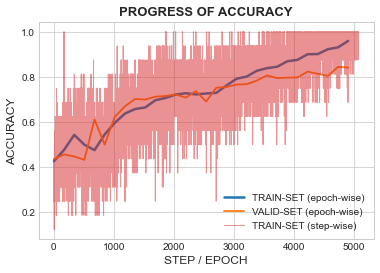

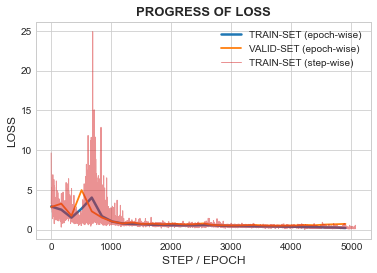



 +++ CONTINGENCY MATRIX +++
[[411.  72.   6.   0.]
 [255. 646.  12.   0.]
 [ 50.  37. 755.   0.]
 [ 25.   1.   0. 761.]]


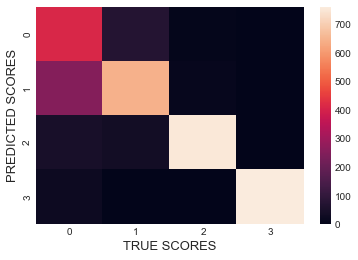


 > LOSS : 0.7646
 > ACCURACY : 0.8489
 > MEAN SQUARED ERR : 0.2735

 > MEAN PRECISION@20 : 28.24 %
 > MEAN RECALL@20 : 81.90 %
 > MEAN R PRECISION : 40.90 %
 > MEAN AVG. PRECISION : 78.28 %

 > MEAN NDCG (@100%) : 0.742074
 > (STD) DEV in NDCG (@100%) : 0.141690

 > MEAN NDCG (@20%) : 0.560021
 > (STD) DEV in NDCG (@20%) : 0.181391


In [39]:
baseline = 'bert_nli'
facet = 'method'
Implement(baseline, facet, train=True)


In [40]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : bert_nli <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : bert_nli
 > FACET : result

 EPOCH   1 | T.LOSS : 1.638645 | T.ACC : 0.347264 | V.LOSS : 1.253905 | V.ACC : 0.411348 | DUR : 1.7171
 EPOCH   2 | T.LOSS : 1.230584 | T.ACC : 0.462006 | V.LOSS : 0.993982 | V.ACC : 0.541033 | DUR : 1.7414
 EPOCH   3 | T.LOSS : 0.957083 | T.ACC : 0.542933 | V.LOSS : 0.955942 | V.ACC : 0.564336 | DUR : 1.7391
 EPOCH   4 | T.LOSS : 0.904232 | T.ACC : 0.563450 | V.LOSS : 0.849683 | V.ACC : 0.620061 | DUR : 1.7157
 EPOCH   5 | T.LOSS : 0.796643 | T.ACC : 0.615502 | V.LOSS : 0.825747 | V.ACC : 0.601824 | DUR : 1.7263
 EPOCH   6 | T.LOSS : 0.757113 | T.ACC : 0.658815 | V.LOSS : 0.769751 | V.ACC : 0.695035 | DUR : 1.7678
 EPOCH   7 | T.LOSS : 0.695209 | T.ACC : 0.700608 | V.LOSS : 0.773188 | V.ACC : 0.643364 | DUR : 1.7366
 EPOCH   8 | T.LOSS : 0.653308 | T.ACC : 0.724544 | V.LOSS : 0.711084 | V.ACC : 0.710233 | DUR : 1.7508
 EPOCH   9 | T.LOSS : 0.611830 | T.ACC : 0.751900 | V.LOSS : 0.698240 | V.ACC : 0.719352 | DUR : 1.7191
 EPOCH  10 | T.LOSS :

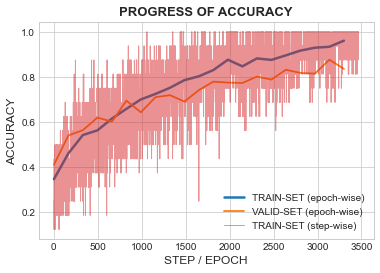

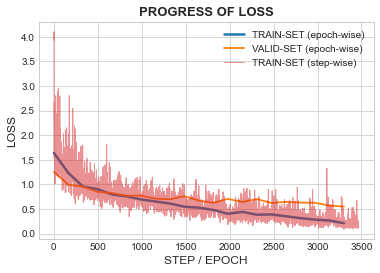



 +++ CONTINGENCY MATRIX +++
[[460. 129.   1.   0.]
 [202. 551.  39.   0.]
 [ 34.  52. 699.   0.]
 [ 57.   6.   0. 731.]]


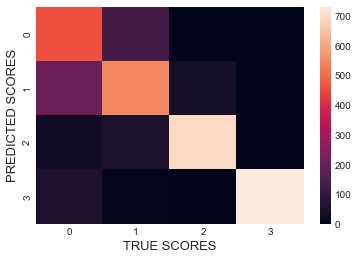


 > LOSS : 0.7647
 > ACCURACY : 0.8244
 > MEAN SQUARED ERR : 0.3712

 > MEAN PRECISION@20 : 35.88 %
 > MEAN RECALL@20 : 83.42 %
 > MEAN R PRECISION : 34.67 %
 > MEAN AVG. PRECISION : 78.93 %

 > MEAN NDCG (@100%) : 0.701085
 > (STD) DEV in NDCG (@100%) : 0.136071

 > MEAN NDCG (@20%) : 0.549835
 > (STD) DEV in NDCG (@20%) : 0.154256


In [41]:
baseline = 'bert_nli'
facet = 'result'
Implement(baseline, facet, train=True) train=True)


In [42]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : bert_nli <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.9802
 [ TITLE ] Lea

### [ AGGREGATED ]

In [39]:
baseline = 'bert_nli'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 75.431 %
 > (AGG) STD-DEV in NDCG (@100%) : 13.097 %
 > (AGG) MEAN NDCG (@20%) : 58.789 %
 > (AGG) STD-DEV in NDCG (@20%) : 15.323 %
 > (AGG) MEAN PRECISION@20 : 30.30 %
 > (AGG) MEAN RECALL@20 : 69.98 %
 > (AGG) MEAN R PRECISION : 35.64 %
 > (AGG) MEAN AVG. PRECISION : 72.57 %


## BERT-based PP Baseline (bert_pp)

### [ BACKGROUND ]


 > BASELINE : bert_pp
 > FACET : background

 EPOCH   1 | T.LOSS : 1.448734 | T.ACC : 0.301458 | V.LOSS : 1.483484 | V.ACC : 0.318818 | DUR : 1.0993
 EPOCH   2 | T.LOSS : 1.343790 | T.ACC : 0.376093 | V.LOSS : 1.300793 | V.ACC : 0.357698 | DUR : 1.0981
 EPOCH   3 | T.LOSS : 1.269093 | T.ACC : 0.396501 | V.LOSS : 1.248227 | V.ACC : 0.401244 | DUR : 1.0983
 EPOCH   4 | T.LOSS : 1.118161 | T.ACC : 0.469388 | V.LOSS : 1.147028 | V.ACC : 0.475894 | DUR : 1.0965
 EPOCH   5 | T.LOSS : 1.033470 | T.ACC : 0.531195 | V.LOSS : 1.149366 | V.ACC : 0.494557 | DUR : 1.0980
 EPOCH   6 | T.LOSS : 0.998665 | T.ACC : 0.516035 | V.LOSS : 1.152287 | V.ACC : 0.513219 | DUR : 1.0963
 EPOCH   7 | T.LOSS : 0.896213 | T.ACC : 0.562099 | V.LOSS : 1.158356 | V.ACC : 0.533437 | DUR : 1.0976
 EPOCH   8 | T.LOSS : 0.861103 | T.ACC : 0.573178 | V.LOSS : 1.048321 | V.ACC : 0.562986 | DUR : 1.0974
 EPOCH   9 | T.LOSS : 0.765494 | T.ACC : 0.604082 | V.LOSS : 1.105299 | V.ACC : 0.534992 | DUR : 1.1045
 EPOCH  10 | T.LOS

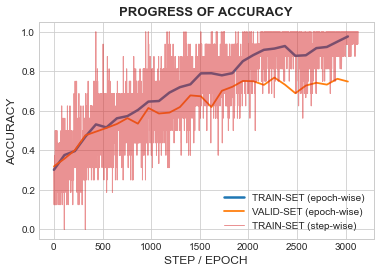

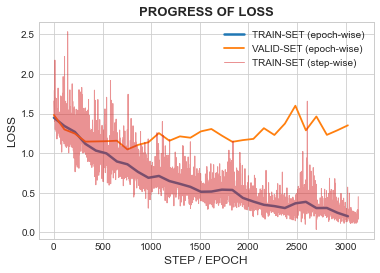



 +++ CONTINGENCY MATRIX +++
[[214.  98.  41.   0.]
 [183. 306.  18.   1.]
 [ 61.  29. 428.   0.]
 [ 32.  57.   2. 460.]]


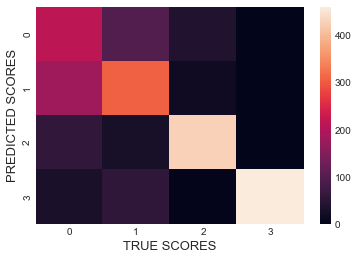


 > LOSS : 1.4940
 > ACCURACY : 0.7295
 > MEAN SQUARED ERR : 0.6518

 > MEAN PRECISION@20 : 37.81 %
 > MEAN RECALL@20 : 65.27 %
 > MEAN R PRECISION : 50.49 %
 > MEAN AVG. PRECISION : 68.47 %

 > MEAN NDCG (@100%) : 0.810675
 > (STD) DEV in NDCG (@100%) : 0.058522

 > MEAN NDCG (@20%) : 0.644444
 > (STD) DEV in NDCG (@20%) : 0.083767


In [46]:
baseline = 'bert_pp'
facet = 'background'
Implement(baseline, facet, train=True)


In [47]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : bert_pp <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using 

### [ METHOD ]


 > BASELINE : bert_pp
 > FACET : method

 EPOCH   1 | T.LOSS : 1.399327 | T.ACC : 0.304606 | V.LOSS : 1.102384 | V.ACC : 0.493558 | DUR : 1.7847
 EPOCH   2 | T.LOSS : 1.005516 | T.ACC : 0.523403 | V.LOSS : 0.950222 | V.ACC : 0.571853 | DUR : 1.7818
 EPOCH   3 | T.LOSS : 0.834791 | T.ACC : 0.624443 | V.LOSS : 0.811390 | V.ACC : 0.646184 | DUR : 1.7677
 EPOCH   4 | T.LOSS : 0.765923 | T.ACC : 0.658990 | V.LOSS : 0.798492 | V.ACC : 0.633300 | DUR : 1.7941
 EPOCH   5 | T.LOSS : 0.670959 | T.ACC : 0.703566 | V.LOSS : 0.808532 | V.ACC : 0.672944 | DUR : 1.8046
 EPOCH   6 | T.LOSS : 0.619384 | T.ACC : 0.742942 | V.LOSS : 0.754832 | V.ACC : 0.729435 | DUR : 1.8217
 EPOCH   7 | T.LOSS : 0.583073 | T.ACC : 0.753343 | V.LOSS : 0.739038 | V.ACC : 0.743310 | DUR : 1.8257
 EPOCH   8 | T.LOSS : 0.527808 | T.ACC : 0.797548 | V.LOSS : 0.710984 | V.ACC : 0.736373 | DUR : 1.8228
 EPOCH   9 | T.LOSS : 0.465833 | T.ACC : 0.832095 | V.LOSS : 0.753133 | V.ACC : 0.751239 | DUR : 1.8323
 EPOCH  10 | T.LOSS : 

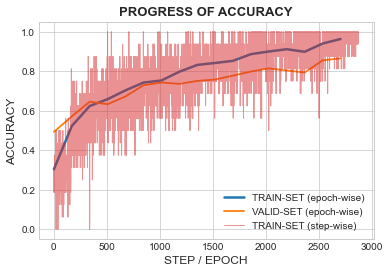

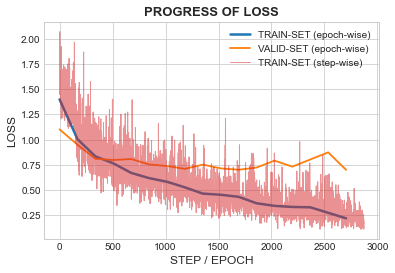



 +++ CONTINGENCY MATRIX +++
[[437.  90.   0.   0.]
 [254. 640.   4.   0.]
 [ 26.  35. 753.   0.]
 [ 25.   2.   0. 765.]]


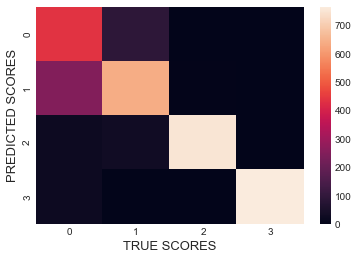


 > LOSS : 0.7387
 > ACCURACY : 0.8562
 > MEAN SQUARED ERR : 0.2375

 > MEAN PRECISION@20 : 32.35 %
 > MEAN RECALL@20 : 96.78 %
 > MEAN R PRECISION : 47.90 %
 > MEAN AVG. PRECISION : 77.16 %

 > MEAN NDCG (@100%) : 0.759027
 > (STD) DEV in NDCG (@100%) : 0.123732

 > MEAN NDCG (@20%) : 0.613786
 > (STD) DEV in NDCG (@20%) : 0.170704


In [48]:
baseline = 'bert_pp'
facet = 'method'
Implement(baseline, facet, train=True)


In [49]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : bert_pp <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subsequ

### [ RESULTS ]


 > BASELINE : bert_pp
 > FACET : result

 EPOCH   1 | T.LOSS : 1.500510 | T.ACC : 0.369301 | V.LOSS : 1.315832 | V.ACC : 0.397163 | DUR : 1.7154
 EPOCH   2 | T.LOSS : 1.200963 | T.ACC : 0.498100 | V.LOSS : 1.139393 | V.ACC : 0.496454 | DUR : 1.7636
 EPOCH   3 | T.LOSS : 1.007728 | T.ACC : 0.544073 | V.LOSS : 1.094670 | V.ACC : 0.523810 | DUR : 1.7758
 EPOCH   4 | T.LOSS : 0.929966 | T.ACC : 0.579787 | V.LOSS : 0.960648 | V.ACC : 0.562310 | DUR : 1.7364
 EPOCH   5 | T.LOSS : 0.854638 | T.ACC : 0.618541 | V.LOSS : 0.946286 | V.ACC : 0.579534 | DUR : 1.7009
 EPOCH   6 | T.LOSS : 0.773133 | T.ACC : 0.666033 | V.LOSS : 0.884481 | V.ACC : 0.629179 | DUR : 1.6943
 EPOCH   7 | T.LOSS : 0.744301 | T.ACC : 0.683131 | V.LOSS : 0.780622 | V.ACC : 0.657548 | DUR : 1.6980
 EPOCH   8 | T.LOSS : 0.665369 | T.ACC : 0.725684 | V.LOSS : 0.688082 | V.ACC : 0.736575 | DUR : 1.7234
 EPOCH   9 | T.LOSS : 0.584156 | T.ACC : 0.788374 | V.LOSS : 0.710738 | V.ACC : 0.687943 | DUR : 1.7125
 EPOCH  10 | T.LOSS : 

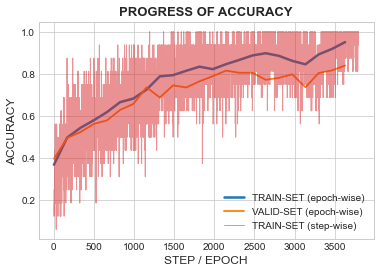

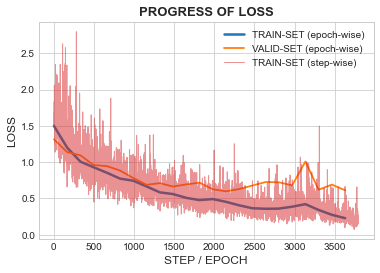



 +++ CONTINGENCY MATRIX +++
[[420.  98.   6.   0.]
 [164. 622.   0.   0.]
 [157.  10. 727.   0.]
 [  3.   0.   0. 754.]]


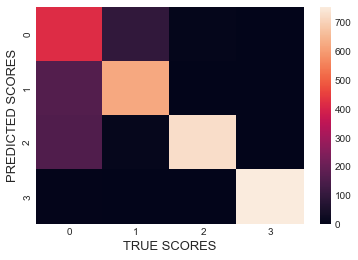


 > LOSS : 0.5481
 > ACCURACY : 0.8521
 > MEAN SQUARED ERR : 0.3212

 > MEAN PRECISION@20 : 37.65 %
 > MEAN RECALL@20 : 85.95 %
 > MEAN R PRECISION : 44.71 %
 > MEAN AVG. PRECISION : 81.92 %

 > MEAN NDCG (@100%) : 0.767224
 > (STD) DEV in NDCG (@100%) : 0.121614

 > MEAN NDCG (@20%) : 0.597014
 > (STD) DEV in NDCG (@20%) : 0.155434


In [50]:
baseline = 'bert_pp'
facet = 'result'
Implement(baseline, facet, train=True)


In [51]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : bert_pp <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 2156506 | GRADED RELEVANCE SCORE : 2.9314
 [ TITLE ] Mult

### [ AGGREGATED ]

In [40]:
baseline = 'bert_pp'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 77.834 %
 > (AGG) STD-DEV in NDCG (@100%) : 10.878 %
 > (AGG) MEAN NDCG (@20%) : 61.789 %
 > (AGG) STD-DEV in NDCG (@20%) : 14.404 %
 > (AGG) MEAN PRECISION@20 : 35.90 %
 > (AGG) MEAN RECALL@20 : 83.01 %
 > (AGG) MEAN R PRECISION : 47.65 %
 > (AGG) MEAN AVG. PRECISION : 76.00 %


## SciBERT Cased Baseline (scibert_cased)

### [ BACKGROUND ]


 > BASELINE : scibert_cased
 > FACET : background

 EPOCH   1 | T.LOSS : 3.789114 | T.ACC : 0.351604 | V.LOSS : 1.809354 | V.ACC : 0.446345 | DUR : 1.1109
 EPOCH   2 | T.LOSS : 1.626264 | T.ACC : 0.423907 | V.LOSS : 1.769323 | V.ACC : 0.407465 | DUR : 1.1152
 EPOCH   3 | T.LOSS : 1.514478 | T.ACC : 0.471137 | V.LOSS : 1.567132 | V.ACC : 0.465008 | DUR : 1.1396
 EPOCH   4 | T.LOSS : 1.400261 | T.ACC : 0.488047 | V.LOSS : 1.449892 | V.ACC : 0.455677 | DUR : 1.1045
 EPOCH   5 | T.LOSS : 1.491292 | T.ACC : 0.482799 | V.LOSS : 2.291876 | V.ACC : 0.410575 | DUR : 1.1008
 EPOCH   6 | T.LOSS : 1.828336 | T.ACC : 0.458892 | V.LOSS : 2.032292 | V.ACC : 0.418351 | DUR : 1.1002
 EPOCH   7 | T.LOSS : 1.872753 | T.ACC : 0.465889 | V.LOSS : 3.994011 | V.ACC : 0.304821 | DUR : 1.1003
 EPOCH   8 | T.LOSS : 1.620692 | T.ACC : 0.479883 | V.LOSS : 1.912532 | V.ACC : 0.491446 | DUR : 1.1149
 EPOCH   9 | T.LOSS : 1.255436 | T.ACC : 0.532945 | V.LOSS : 1.425542 | V.ACC : 0.508554 | DUR : 1.0965
 EPOCH  10 |

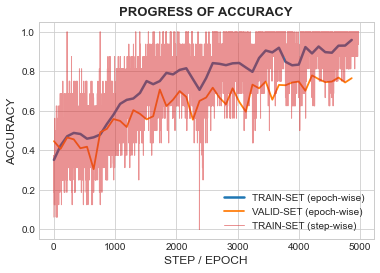

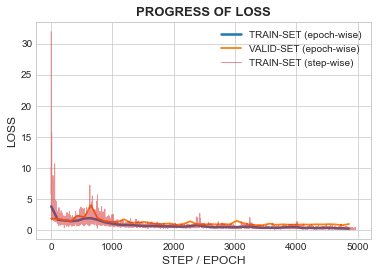



 +++ CONTINGENCY MATRIX +++
[[256.  86.   1.   0.]
 [196. 283.  16.   0.]
 [ 47.  88. 448.   0.]
 [  0.   1.  14. 494.]]


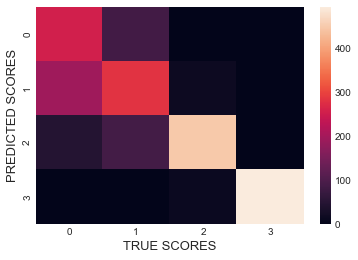


 > LOSS : 0.8364
 > ACCURACY : 0.7674
 > MEAN SQUARED ERR : 0.3088

 > MEAN PRECISION@20 : 50.31 %
 > MEAN RECALL@20 : 81.34 %
 > MEAN R PRECISION : 60.43 %
 > MEAN AVG. PRECISION : 69.20 %

 > MEAN NDCG (@100%) : 0.913479
 > (STD) DEV in NDCG (@100%) : 0.050908

 > MEAN NDCG (@20%) : 0.817245
 > (STD) DEV in NDCG (@20%) : 0.083795


In [53]:
baseline = 'scibert_cased'
facet = 'background'
Implement(baseline, facet, train=True)


In [54]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to 

### [ METHOD ]


 > BASELINE : scibert_cased
 > FACET : method

 EPOCH   1 | T.LOSS : 2.575687 | T.ACC : 0.373700 | V.LOSS : 1.628349 | V.ACC : 0.444995 | DUR : 1.8441
 EPOCH   2 | T.LOSS : 1.677646 | T.ACC : 0.476226 | V.LOSS : 1.563072 | V.ACC : 0.509415 | DUR : 1.8092
 EPOCH   3 | T.LOSS : 1.766044 | T.ACC : 0.485513 | V.LOSS : 5.433516 | V.ACC : 0.408325 | DUR : 1.8087
 EPOCH   4 | T.LOSS : 2.621796 | T.ACC : 0.471025 | V.LOSS : 1.990369 | V.ACC : 0.478692 | DUR : 1.7826
 EPOCH   5 | T.LOSS : 1.065915 | T.ACC : 0.602526 | V.LOSS : 0.809977 | V.ACC : 0.611497 | DUR : 1.7678
 EPOCH   6 | T.LOSS : 0.756442 | T.ACC : 0.649331 | V.LOSS : 0.730093 | V.ACC : 0.638256 | DUR : 1.7347
 EPOCH   7 | T.LOSS : 0.674226 | T.ACC : 0.678678 | V.LOSS : 0.762883 | V.ACC : 0.633300 | DUR : 1.7496
 EPOCH   8 | T.LOSS : 0.647538 | T.ACC : 0.680163 | V.LOSS : 0.704603 | V.ACC : 0.651140 | DUR : 1.7349
 EPOCH   9 | T.LOSS : 0.619144 | T.ACC : 0.692051 | V.LOSS : 0.678074 | V.ACC : 0.667988 | DUR : 1.7305
 EPOCH  10 | T.L

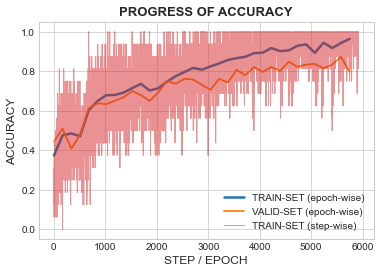

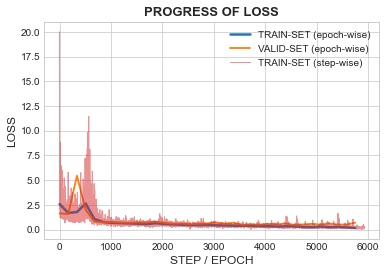



 +++ CONTINGENCY MATRIX +++
[[447.  76. 247.   0.]
 [289. 690.   0.   0.]
 [ 12.   3. 496.   0.]
 [  2.   8.   0. 761.]]


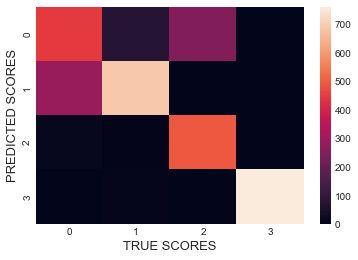


 > LOSS : 0.7296
 > ACCURACY : 0.7898
 > MEAN SQUARED ERR : 0.4797

 > MEAN PRECISION@20 : 23.53 %
 > MEAN RECALL@20 : 66.84 %
 > MEAN R PRECISION : 61.80 %
 > MEAN AVG. PRECISION : 75.98 %

 > MEAN NDCG (@100%) : 0.825144
 > (STD) DEV in NDCG (@100%) : 0.068546

 > MEAN NDCG (@20%) : 0.662371
 > (STD) DEV in NDCG (@20%) : 0.115134


In [55]:
baseline = 'scibert_cased'
facet = 'method'
Implement(baseline, facet, train=True)


In [56]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is s

### [ RESULTS ]


 > BASELINE : scibert_cased
 > FACET : result

 EPOCH   1 | T.LOSS : 1.872878 | T.ACC : 0.335486 | V.LOSS : 1.327745 | V.ACC : 0.502533 | DUR : 1.7496
 EPOCH   2 | T.LOSS : 1.372911 | T.ACC : 0.460866 | V.LOSS : 1.363069 | V.ACC : 0.421479 | DUR : 1.7379
 EPOCH   3 | T.LOSS : 1.058478 | T.ACC : 0.532675 | V.LOSS : 0.975491 | V.ACC : 0.560284 | DUR : 1.6797
 EPOCH   4 | T.LOSS : 0.907551 | T.ACC : 0.578647 | V.LOSS : 0.972612 | V.ACC : 0.567376 | DUR : 1.6851
 EPOCH   5 | T.LOSS : 0.846306 | T.ACC : 0.564970 | V.LOSS : 0.927532 | V.ACC : 0.603850 | DUR : 1.6756
 EPOCH   6 | T.LOSS : 0.758057 | T.ACC : 0.613982 | V.LOSS : 0.942912 | V.ACC : 0.594732 | DUR : 1.6819
 EPOCH   7 | T.LOSS : 0.770011 | T.ACC : 0.622340 | V.LOSS : 0.854173 | V.ACC : 0.572442 | DUR : 1.6821
 EPOCH   8 | T.LOSS : 0.730703 | T.ACC : 0.620441 | V.LOSS : 0.928251 | V.ACC : 0.591692 | DUR : 1.6816
 EPOCH   9 | T.LOSS : 0.703628 | T.ACC : 0.652356 | V.LOSS : 0.754873 | V.ACC : 0.716312 | DUR : 1.6812
 EPOCH  10 | T.L

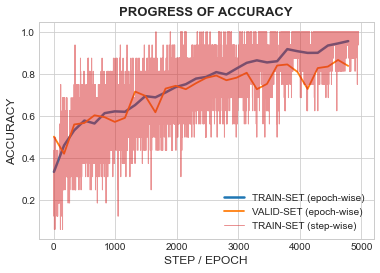

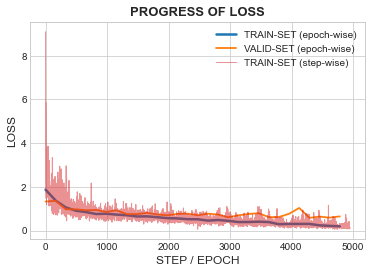



 +++ CONTINGENCY MATRIX +++
[[401. 109.   6.   0.]
 [136. 618.   0.   0.]
 [188.  15. 741.   0.]
 [  1.   0.   0. 746.]]


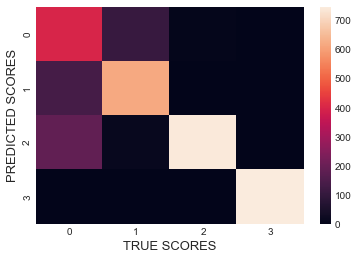


 > LOSS : 0.5854
 > ACCURACY : 0.8463
 > MEAN SQUARED ERR : 0.3529

 > MEAN PRECISION@20 : 33.53 %
 > MEAN RECALL@20 : 79.84 %
 > MEAN R PRECISION : 50.18 %
 > MEAN AVG. PRECISION : 81.56 %

 > MEAN NDCG (@100%) : 0.785184
 > (STD) DEV in NDCG (@100%) : 0.120367

 > MEAN NDCG (@20%) : 0.608330
 > (STD) DEV in NDCG (@20%) : 0.177667


In [57]:
baseline = 'scibert_cased'
facet = 'result'
Implement(baseline, facet, train=True)


In [58]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : scibert_cased <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 10076790 | GRADED RELEVANCE SCORE : 2.9583
 [ TITLE

### [ AGGREGATED ]

In [41]:
baseline = 'scibert_cased'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 83.982 %
 > (AGG) STD-DEV in NDCG (@100%) : 10.088 %
 > (AGG) MEAN NDCG (@20%) : 69.356 %
 > (AGG) STD-DEV in NDCG (@20%) : 15.869 %
 > (AGG) MEAN PRECISION@20 : 35.50 %
 > (AGG) MEAN RECALL@20 : 75.90 %
 > (AGG) MEAN R PRECISION : 57.41 %
 > (AGG) MEAN AVG. PRECISION : 75.71 %


## SciBERT Uncased Baseline (scibert_uncased)

### [ BACKGROUND ]


 > BASELINE : scibert_uncased
 > FACET : background

 EPOCH   1 | T.LOSS : 5.105610 | T.ACC : 0.270554 | V.LOSS : 4.572278 | V.ACC : 0.284603 | DUR : 1.1036
 EPOCH   2 | T.LOSS : 3.387527 | T.ACC : 0.318950 | V.LOSS : 3.092402 | V.ACC : 0.331260 | DUR : 1.1129
 EPOCH   3 | T.LOSS : 5.421059 | T.ACC : 0.337609 | V.LOSS : 4.454558 | V.ACC : 0.393468 | DUR : 1.1206
 EPOCH   4 | T.LOSS : 6.209843 | T.ACC : 0.338776 | V.LOSS : 6.502161 | V.ACC : 0.345257 | DUR : 1.1092
 EPOCH   5 | T.LOSS : 4.546789 | T.ACC : 0.366181 | V.LOSS : 4.757859 | V.ACC : 0.340591 | DUR : 1.1711
 EPOCH   6 | T.LOSS : 3.068837 | T.ACC : 0.411662 | V.LOSS : 5.505757 | V.ACC : 0.356143 | DUR : 1.1724
 EPOCH   7 | T.LOSS : 2.352540 | T.ACC : 0.435569 | V.LOSS : 2.119301 | V.ACC : 0.443235 | DUR : 1.1686
 EPOCH   8 | T.LOSS : 1.905748 | T.ACC : 0.460058 | V.LOSS : 2.274004 | V.ACC : 0.412131 | DUR : 1.1142
 EPOCH   9 | T.LOSS : 1.870497 | T.ACC : 0.466472 | V.LOSS : 2.360812 | V.ACC : 0.452566 | DUR : 1.1095
 EPOCH  10

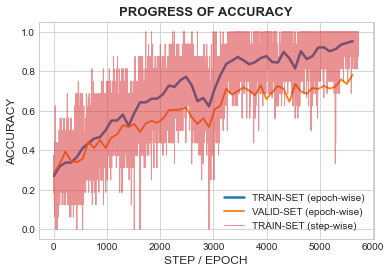

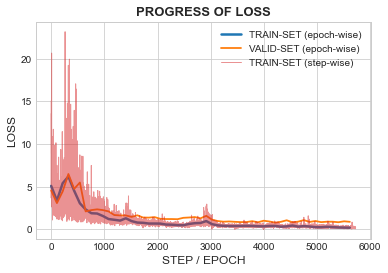



 +++ CONTINGENCY MATRIX +++
[[256. 123.  64.   0.]
 [154. 326.   9.   0.]
 [ 74.  33. 425.   1.]
 [  1.   1.   6. 457.]]


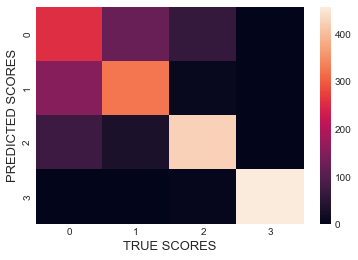


 > LOSS : 0.8240
 > ACCURACY : 0.7585
 > MEAN SQUARED ERR : 0.4617

 > MEAN PRECISION@20 : 49.06 %
 > MEAN RECALL@20 : 79.41 %
 > MEAN R PRECISION : 62.54 %
 > MEAN AVG. PRECISION : 71.55 %

 > MEAN NDCG (@100%) : 0.871347
 > (STD) DEV in NDCG (@100%) : 0.078215

 > MEAN NDCG (@20%) : 0.755741
 > (STD) DEV in NDCG (@20%) : 0.123607


In [60]:
baseline = 'scibert_uncased'
facet = 'background'
Implement(baseline, facet, train=True)


In [61]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language t

### [ METHOD ]


 > BASELINE : scibert_uncased
 > FACET : method

 EPOCH   1 | T.LOSS : 3.605878 | T.ACC : 0.325409 | V.LOSS : 2.801334 | V.ACC : 0.385530 | DUR : 1.7770
 EPOCH   2 | T.LOSS : 3.116881 | T.ACC : 0.343239 | V.LOSS : 3.560805 | V.ACC : 0.339941 | DUR : 1.7909
 EPOCH   3 | T.LOSS : 2.765079 | T.ACC : 0.359212 | V.LOSS : 1.756922 | V.ACC : 0.411298 | DUR : 1.7843
 EPOCH   4 | T.LOSS : 1.459336 | T.ACC : 0.425706 | V.LOSS : 1.647710 | V.ACC : 0.425173 | DUR : 1.8533
 EPOCH   5 | T.LOSS : 1.672734 | T.ACC : 0.409361 | V.LOSS : 7.690136 | V.ACC : 0.279485 | DUR : 1.8367
 EPOCH   6 | T.LOSS : 2.299613 | T.ACC : 0.482912 | V.LOSS : 5.679754 | V.ACC : 0.305253 | DUR : 1.7786
 EPOCH   7 | T.LOSS : 1.894517 | T.ACC : 0.505944 | V.LOSS : 1.501690 | V.ACC : 0.529237 | DUR : 1.8344
 EPOCH   8 | T.LOSS : 0.956551 | T.ACC : 0.600669 | V.LOSS : 1.005006 | V.ACC : 0.607532 | DUR : 1.8297
 EPOCH   9 | T.LOSS : 0.762077 | T.ACC : 0.661590 | V.LOSS : 0.955980 | V.ACC : 0.620416 | DUR : 1.8362
 EPOCH  10 | T

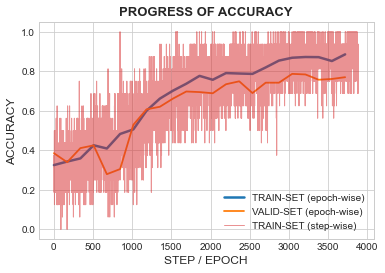

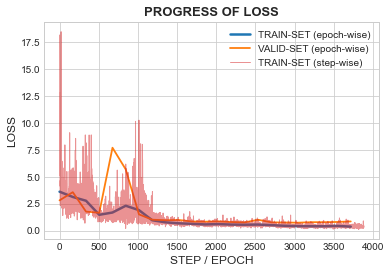



 +++ CONTINGENCY MATRIX +++
[[424. 113.   0.  13.]
 [250. 518.  43.   0.]
 [ 64. 134. 688.   0.]
 [ 49.   0.   0. 735.]]


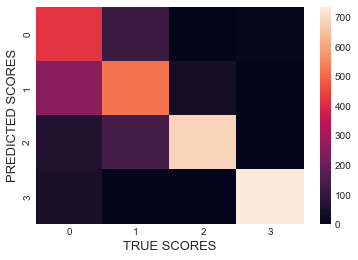


 > LOSS : 0.8644
 > ACCURACY : 0.7803
 > MEAN SQUARED ERR : 0.4467

 > MEAN PRECISION@20 : 22.06 %
 > MEAN RECALL@20 : 72.76 %
 > MEAN R PRECISION : 27.10 %
 > MEAN AVG. PRECISION : 79.13 %

 > MEAN NDCG (@100%) : 0.662235
 > (STD) DEV in NDCG (@100%) : 0.090806

 > MEAN NDCG (@20%) : 0.437744
 > (STD) DEV in NDCG (@20%) : 0.115939


In [62]:
baseline = 'scibert_uncased'
facet = 'method'
Implement(baseline, facet, train=True)


In [63]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is

### [ RESULTS ]


 > BASELINE : scibert_uncased
 > FACET : result

 EPOCH   1 | T.LOSS : 2.623532 | T.ACC : 0.291033 | V.LOSS : 1.733786 | V.ACC : 0.310030 | DUR : 1.6836
 EPOCH   2 | T.LOSS : 1.829005 | T.ACC : 0.344225 | V.LOSS : 1.408521 | V.ACC : 0.377913 | DUR : 1.6876
 EPOCH   3 | T.LOSS : 1.610359 | T.ACC : 0.363982 | V.LOSS : 2.632966 | V.ACC : 0.335360 | DUR : 1.6856
 EPOCH   4 | T.LOSS : 1.424048 | T.ACC : 0.458587 | V.LOSS : 1.320150 | V.ACC : 0.514691 | DUR : 1.6863
 EPOCH   5 | T.LOSS : 1.208630 | T.ACC : 0.492021 | V.LOSS : 1.210125 | V.ACC : 0.511651 | DUR : 1.6868
 EPOCH   6 | T.LOSS : 0.975630 | T.ACC : 0.572188 | V.LOSS : 0.950223 | V.ACC : 0.551165 | DUR : 1.6841
 EPOCH   7 | T.LOSS : 0.806911 | T.ACC : 0.636018 | V.LOSS : 0.890163 | V.ACC : 0.632219 | DUR : 1.6838
 EPOCH   8 | T.LOSS : 0.755845 | T.ACC : 0.658055 | V.LOSS : 0.839561 | V.ACC : 0.595745 | DUR : 1.6856
 EPOCH   9 | T.LOSS : 0.673518 | T.ACC : 0.694909 | V.LOSS : 0.767636 | V.ACC : 0.672746 | DUR : 1.6830
 EPOCH  10 | T

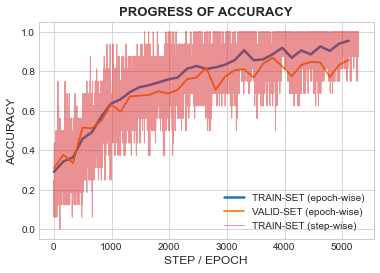

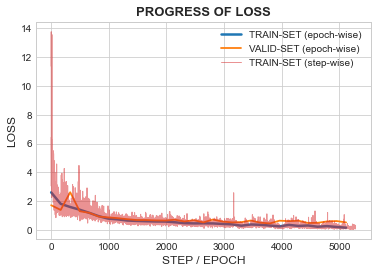



 +++ CONTINGENCY MATRIX +++
[[412.  58.  53.   0.]
 [236. 649.   0.   0.]
 [ 93.  13. 693.   7.]
 [  0.   0.   0. 747.]]


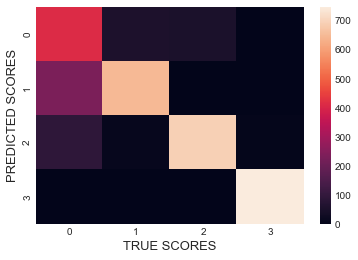


 > LOSS : 0.5432
 > ACCURACY : 0.8446
 > MEAN SQUARED ERR : 0.3033

 > MEAN PRECISION@20 : 40.00 %
 > MEAN RECALL@20 : 84.58 %
 > MEAN R PRECISION : 58.32 %
 > MEAN AVG. PRECISION : 79.19 %

 > MEAN NDCG (@100%) : 0.826797
 > (STD) DEV in NDCG (@100%) : 0.130978

 > MEAN NDCG (@20%) : 0.693541
 > (STD) DEV in NDCG (@20%) : 0.179622


In [64]:
baseline = 'scibert_uncased'
facet = 'result'
Implement(baseline, facet, train=True)


In [65]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : scibert_uncased <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.9153
 [ TITL

### [ AGGREGATED ]

In [42]:
baseline = 'scibert_uncased'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 78.510 %
 > (AGG) STD-DEV in NDCG (@100%) : 13.674 %
 > (AGG) MEAN NDCG (@20%) : 62.647 %
 > (AGG) STD-DEV in NDCG (@20%) : 19.853 %
 > (AGG) MEAN PRECISION@20 : 36.80 %
 > (AGG) MEAN RECALL@20 : 78.91 %
 > (AGG) MEAN R PRECISION : 49.06 %
 > (AGG) MEAN AVG. PRECISION : 76.72 %


## SPECTER Baseline (specter)

### [ BACKGROUND ]


 > BASELINE : specter
 > FACET : background

 EPOCH   1 | T.LOSS : 2.994797 | T.ACC : 0.383673 | V.LOSS : 2.058738 | V.ACC : 0.451011 | DUR : 1.0997
 EPOCH   2 | T.LOSS : 1.846833 | T.ACC : 0.442566 | V.LOSS : 2.262854 | V.ACC : 0.447900 | DUR : 1.1020
 EPOCH   3 | T.LOSS : 2.276082 | T.ACC : 0.422741 | V.LOSS : 3.324686 | V.ACC : 0.354588 | DUR : 1.1019
 EPOCH   4 | T.LOSS : 2.349855 | T.ACC : 0.433819 | V.LOSS : 2.582789 | V.ACC : 0.446345 | DUR : 1.1010
 EPOCH   5 | T.LOSS : 2.211076 | T.ACC : 0.460641 | V.LOSS : 2.682837 | V.ACC : 0.424572 | DUR : 1.1059
 EPOCH   6 | T.LOSS : 2.200272 | T.ACC : 0.444898 | V.LOSS : 2.212608 | V.ACC : 0.432348 | DUR : 1.1018
 EPOCH   7 | T.LOSS : 1.593990 | T.ACC : 0.488047 | V.LOSS : 1.666602 | V.ACC : 0.468118 | DUR : 1.0994
 EPOCH   8 | T.LOSS : 1.350656 | T.ACC : 0.493878 | V.LOSS : 1.673158 | V.ACC : 0.474339 | DUR : 1.1009
 EPOCH   9 | T.LOSS : 0.953666 | T.ACC : 0.545189 | V.LOSS : 1.257761 | V.ACC : 0.534992 | DUR : 1.1003
 EPOCH  10 | T.LOS

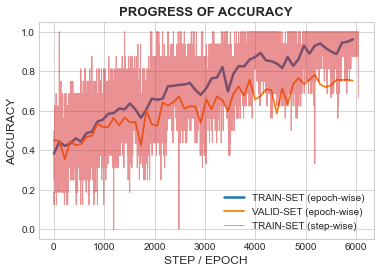

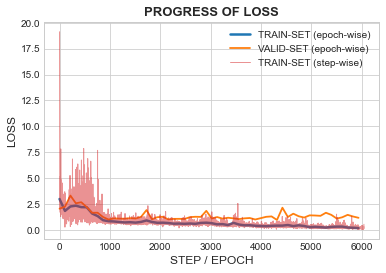



 +++ CONTINGENCY MATRIX +++
[[311.  87.   2.   0.]
 [136. 362.   9.  22.]
 [  1.  12. 370.   0.]
 [ 28.  43.  91. 456.]]


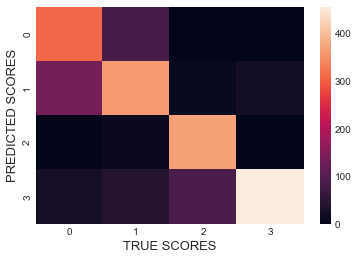


 > LOSS : 0.9487
 > ACCURACY : 0.7767
 > MEAN SQUARED ERR : 0.4451

 > MEAN PRECISION@20 : 51.87 %
 > MEAN RECALL@20 : 84.41 %
 > MEAN R PRECISION : 59.18 %
 > MEAN AVG. PRECISION : 66.21 %

 > MEAN NDCG (@100%) : 0.843679
 > (STD) DEV in NDCG (@100%) : 0.076772

 > MEAN NDCG (@20%) : 0.734160
 > (STD) DEV in NDCG (@20%) : 0.107490


In [67]:
baseline = 'specter'
facet = 'background'
Implement(baseline, facet, train=True) train=True)


In [68]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : specter <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using 

### [ METHOD ]


 > BASELINE : specter
 > FACET : method

 EPOCH   1 | T.LOSS : 2.526048 | T.ACC : 0.317979 | V.LOSS : 2.605810 | V.ACC : 0.323092 | DUR : 1.7189
 EPOCH   2 | T.LOSS : 1.835268 | T.ACC : 0.378157 | V.LOSS : 1.584139 | V.ACC : 0.399405 | DUR : 1.7476
 EPOCH   3 | T.LOSS : 1.543233 | T.ACC : 0.399331 | V.LOSS : 1.635795 | V.ACC : 0.374628 | DUR : 1.8200
 EPOCH   4 | T.LOSS : 1.378709 | T.ACC : 0.436107 | V.LOSS : 1.369184 | V.ACC : 0.438057 | DUR : 1.7374
 EPOCH   5 | T.LOSS : 1.284907 | T.ACC : 0.461367 | V.LOSS : 1.361706 | V.ACC : 0.394450 | DUR : 1.8297
 EPOCH   6 | T.LOSS : 1.148289 | T.ACC : 0.509287 | V.LOSS : 1.210896 | V.ACC : 0.551041 | DUR : 1.7829
 EPOCH   7 | T.LOSS : 1.072843 | T.ACC : 0.518945 | V.LOSS : 1.192557 | V.ACC : 0.489594 | DUR : 1.7250
 EPOCH   8 | T.LOSS : 0.978868 | T.ACC : 0.504086 | V.LOSS : 1.083023 | V.ACC : 0.484638 | DUR : 1.7199
 EPOCH   9 | T.LOSS : 0.879577 | T.ACC : 0.527489 | V.LOSS : 1.009727 | V.ACC : 0.528246 | DUR : 1.7205
 EPOCH  10 | T.LOSS : 

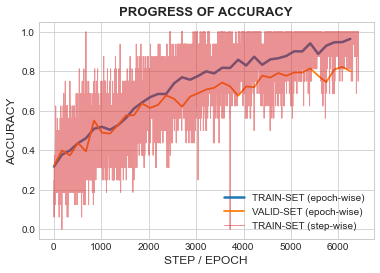

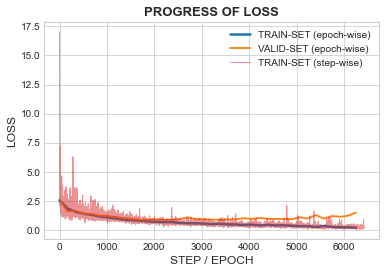



 +++ CONTINGENCY MATRIX +++
[[378.  20.   4.  11.]
 [165. 686. 175.   0.]
 [221.  39. 591.   0.]
 [ 13.   3.   0. 725.]]


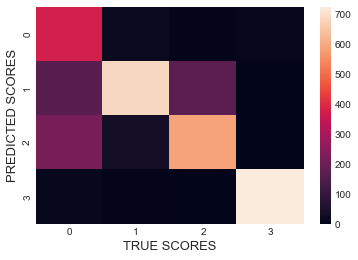


 > LOSS : 1.5630
 > ACCURACY : 0.7852
 > MEAN SQUARED ERR : 0.5038

 > MEAN PRECISION@20 : 22.06 %
 > MEAN RECALL@20 : 64.32 %
 > MEAN R PRECISION : 26.05 %
 > MEAN AVG. PRECISION : 81.66 %

 > MEAN NDCG (@100%) : 0.648922
 > (STD) DEV in NDCG (@100%) : 0.151024

 > MEAN NDCG (@20%) : 0.394886
 > (STD) DEV in NDCG (@20%) : 0.224114


In [69]:
baseline = 'specter'
facet = 'method'
Implement(baseline, facet, train=True)


In [70]:
QBERetrieveSciArticles(baseline, facet, '10010426')



 >>> BASELINE : specter <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] And That's A Fact: Distinguishing Factual and Emotional Argumentation in Online Dialogue
 [ ABSTRACT ] 
 We investigate the characteristics of factual and emotional argumentation styles observed in online debates.
 Using an annotated set of"factual"and"feeling"debate forum posts, we extract patterns that are highly correlated with factual and emotional arguments, and then apply a bootstrapping methodology to find new patterns in a larger pool of unannotated forum posts.
 This process automatically produces a large set of patterns representing linguistic expressions that are highly correlated with factual and emotional language.
 Finally, we analyze the most discriminating patterns to better understand the defining characteristics of factual and emotional arguments.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 6541910 | GRADED RELEVANCE SCORE : 2.9840
 [ TITLE ] Learning Extraction Patterns For S

### [ RESULTS ]


 > BASELINE : specter
 > FACET : result

 EPOCH   1 | T.LOSS : 2.983791 | T.ACC : 0.328267 | V.LOSS : 2.660785 | V.ACC : 0.318136 | DUR : 1.6874
 EPOCH   2 | T.LOSS : 2.238790 | T.ACC : 0.392857 | V.LOSS : 2.141690 | V.ACC : 0.409321 | DUR : 1.7010
 EPOCH   3 | T.LOSS : 1.797332 | T.ACC : 0.423252 | V.LOSS : 3.240351 | V.ACC : 0.272543 | DUR : 1.6873
 EPOCH   4 | T.LOSS : 1.624869 | T.ACC : 0.464666 | V.LOSS : 1.924322 | V.ACC : 0.377913 | DUR : 1.6888
 EPOCH   5 | T.LOSS : 1.311534 | T.ACC : 0.464666 | V.LOSS : 1.238721 | V.ACC : 0.416413 | DUR : 1.6878
 EPOCH   6 | T.LOSS : 1.023050 | T.ACC : 0.524696 | V.LOSS : 1.081355 | V.ACC : 0.496454 | DUR : 1.6849
 EPOCH   7 | T.LOSS : 0.901684 | T.ACC : 0.554711 | V.LOSS : 1.050916 | V.ACC : 0.545086 | DUR : 1.6881
 EPOCH   8 | T.LOSS : 0.830573 | T.ACC : 0.577508 | V.LOSS : 1.033077 | V.ACC : 0.564336 | DUR : 1.6882
 EPOCH   9 | T.LOSS : 0.782659 | T.ACC : 0.590426 | V.LOSS : 0.870738 | V.ACC : 0.573455 | DUR : 1.6868
 EPOCH  10 | T.LOSS : 

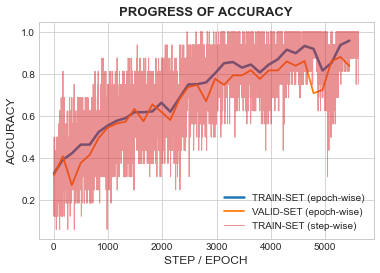

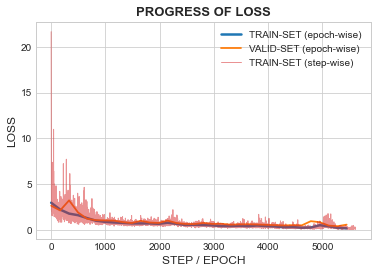



 +++ CONTINGENCY MATRIX +++
[[503.  58.   3.   0.]
 [203. 618.  14.   0.]
 [ 38.  63. 642.   0.]
 [  5.   2.  81. 731.]]


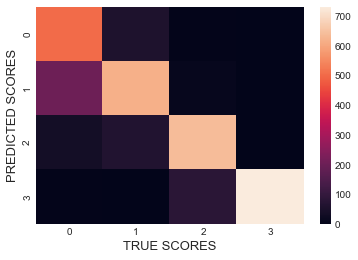


 > LOSS : 0.5967
 > ACCURACY : 0.8423
 > MEAN SQUARED ERR : 0.2148

 > MEAN PRECISION@20 : 44.41 %
 > MEAN RECALL@20 : 93.89 %
 > MEAN R PRECISION : 68.93 %
 > MEAN AVG. PRECISION : 75.89 %

 > MEAN NDCG (@100%) : 0.894454
 > (STD) DEV in NDCG (@100%) : 0.084812

 > MEAN NDCG (@20%) : 0.809749
 > (STD) DEV in NDCG (@20%) : 0.130913


In [71]:
baseline = 'specter'
facet = 'result'
Implement(baseline, facet, train=True)


In [72]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : specter <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.9984
 [ TITLE ] Lear

### [ AGGREGATED ]

In [43]:
baseline = 'specter'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 79.473 %
 > (AGG) STD-DEV in NDCG (@100%) : 15.318 %
 > (AGG) MEAN NDCG (@20%) : 64.451 %
 > (AGG) STD-DEV in NDCG (@20%) : 24.422 %
 > (AGG) MEAN PRECISION@20 : 39.20 %
 > (AGG) MEAN RECALL@20 : 80.80 %
 > (AGG) MEAN R PRECISION : 51.23 %
 > (AGG) MEAN AVG. PRECISION : 74.76 %


## SimCSE Baseline (simcse)

### [ BACKGROUND ]


 > BASELINE : susimcse
 > FACET : background

 EPOCH   1 | T.LOSS : 1.609956 | T.ACC : 0.282216 | V.LOSS : 1.462066 | V.ACC : 0.318818 | DUR : 1.1960
 EPOCH   2 | T.LOSS : 1.441516 | T.ACC : 0.356268 | V.LOSS : 1.459915 | V.ACC : 0.374806 | DUR : 1.0902
 EPOCH   3 | T.LOSS : 1.290113 | T.ACC : 0.388338 | V.LOSS : 1.557626 | V.ACC : 0.353033 | DUR : 1.0899
 EPOCH   4 | T.LOSS : 1.243876 | T.ACC : 0.401749 | V.LOSS : 1.209785 | V.ACC : 0.424572 | DUR : 1.0874
 EPOCH   5 | T.LOSS : 1.198320 | T.ACC : 0.409913 | V.LOSS : 1.431032 | V.ACC : 0.395023 | DUR : 1.0867
 EPOCH   6 | T.LOSS : 1.165718 | T.ACC : 0.411079 | V.LOSS : 1.181055 | V.ACC : 0.419907 | DUR : 1.0880
 EPOCH   7 | T.LOSS : 1.068455 | T.ACC : 0.436152 | V.LOSS : 1.120270 | V.ACC : 0.437014 | DUR : 1.0869
 EPOCH   8 | T.LOSS : 1.004541 | T.ACC : 0.460641 | V.LOSS : 1.160889 | V.ACC : 0.435459 | DUR : 1.1002
 EPOCH   9 | T.LOSS : 1.026797 | T.ACC : 0.444315 | V.LOSS : 1.277346 | V.ACC : 0.393468 | DUR : 1.0983
 EPOCH  10 | T.LO

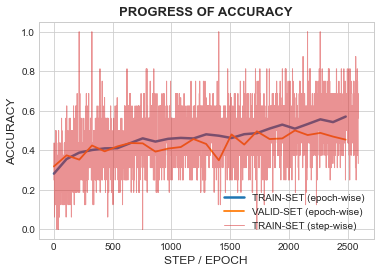

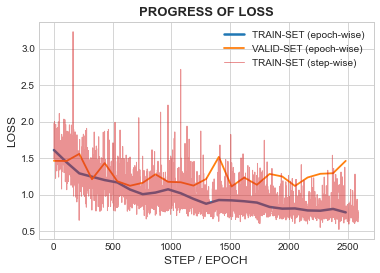



 +++ CONTINGENCY MATRIX +++
[[224. 141.   2.   0.]
 [160. 179.  36.   0.]
 [ 48.  64. 351. 407.]
 [ 68.  82.  82.  86.]]


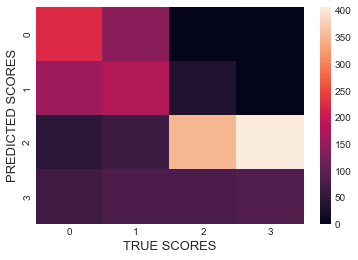


 > LOSS : 1.4401
 > ACCURACY : 0.4352
 > MEAN SQUARED ERR : 1.0518

 > MEAN PRECISION@20 : 30.00 %
 > MEAN RECALL@20 : 48.68 %
 > MEAN R PRECISION : 29.71 %
 > MEAN AVG. PRECISION : 69.27 %

 > MEAN NDCG (@100%) : 0.727034
 > (STD) DEV in NDCG (@100%) : 0.099197

 > MEAN NDCG (@20%) : 0.505458
 > (STD) DEV in NDCG (@20%) : 0.155159


In [35]:
baseline = 'susimcse'
facet = 'background'
Implement(baseline, facet, train=True) train=True)


In [36]:
QBERetrieveSciArticles(baseline, facet, '10695055')



 >>> BASELINE : susimcse <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] Naturalizing a Programming Language via Interactive Learning
 [ ABSTRACT ] 
 Our goal is to create a convenient natural language interface for performing well-specified but complex actions such as analyzing data, manipulating text, and querying databases.
 However, existing natural language interfaces for such tasks are quite primitive compared to the power one wields with a programming language.
 To bridge this gap, we start with a core programming language and allow users to"naturalize"the core language incrementally by defining alternative, more natural syntax and increasingly complex concepts in terms of compositions of simpler ones.
 In a voxel world, we show that a community of users can simultaneously teach a common system a diverse language and use it to build hundreds of complex voxel structures.
 Over the course of three days, these users went from using only the core language to using

### [ METHOD ]


 > BASELINE : susimcse
 > FACET : method

 EPOCH   1 | T.LOSS : 1.229132 | T.ACC : 0.425706 | V.LOSS : 0.994716 | V.ACC : 0.508424 | DUR : 1.7764
 EPOCH   2 | T.LOSS : 0.964973 | T.ACC : 0.498886 | V.LOSS : 0.932050 | V.ACC : 0.509415 | DUR : 1.7199
 EPOCH   3 | T.LOSS : 0.910602 | T.ACC : 0.536776 | V.LOSS : 0.908754 | V.ACC : 0.522299 | DUR : 1.7171
 EPOCH   4 | T.LOSS : 0.864166 | T.ACC : 0.553120 | V.LOSS : 0.834433 | V.ACC : 0.537166 | DUR : 1.7302
 EPOCH   5 | T.LOSS : 0.825849 | T.ACC : 0.571694 | V.LOSS : 0.831110 | V.ACC : 0.571853 | DUR : 1.7399
 EPOCH   6 | T.LOSS : 0.878521 | T.ACC : 0.567608 | V.LOSS : 0.892146 | V.ACC : 0.550050 | DUR : 1.7594
 EPOCH   7 | T.LOSS : 0.840908 | T.ACC : 0.578752 | V.LOSS : 1.102529 | V.ACC : 0.490585 | DUR : 1.7227
 EPOCH   8 | T.LOSS : 0.892995 | T.ACC : 0.547920 | V.LOSS : 0.819579 | V.ACC : 0.585728 | DUR : 1.7266
 EPOCH   9 | T.LOSS : 1.013728 | T.ACC : 0.516716 | V.LOSS : 0.847754 | V.ACC : 0.543112 | DUR : 1.7249
 EPOCH  10 | T.LOSS :

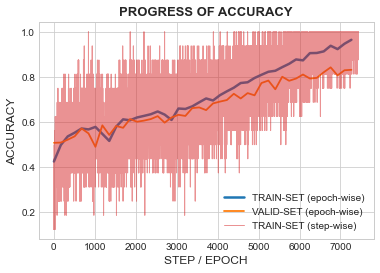

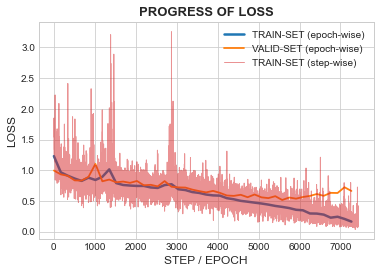



 +++ CONTINGENCY MATRIX +++
[[400. 113.   8.   0.]
 [198. 672.   0.   0.]
 [119.   6. 754.   0.]
 [ 21.   6.   0. 734.]]


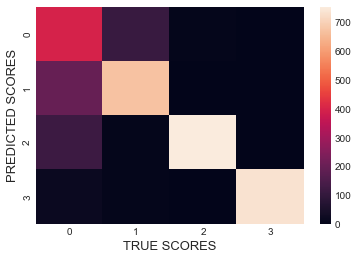


 > LOSS : 0.6392
 > ACCURACY : 0.8446
 > MEAN SQUARED ERR : 0.3425

 > MEAN PRECISION@20 : 27.65 %
 > MEAN RECALL@20 : 87.78 %
 > MEAN R PRECISION : 34.52 %
 > MEAN AVG. PRECISION : 81.22 %

 > MEAN NDCG (@100%) : 0.697978
 > (STD) DEV in NDCG (@100%) : 0.081919

 > MEAN NDCG (@20%) : 0.483512
 > (STD) DEV in NDCG (@20%) : 0.121445


In [37]:
baseline = 'susimcse'
facet = 'method'
Implement(baseline, facet, train=True)


In [38]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : susimcse <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : susimcse
 > FACET : result

 EPOCH   1 | T.LOSS : 1.369174 | T.ACC : 0.329027 | V.LOSS : 1.288042 | V.ACC : 0.379939 | DUR : 1.7033
 EPOCH   2 | T.LOSS : 1.245491 | T.ACC : 0.419833 | V.LOSS : 1.206782 | V.ACC : 0.429585 | DUR : 1.7743
 EPOCH   3 | T.LOSS : 1.122863 | T.ACC : 0.444909 | V.LOSS : 1.093446 | V.ACC : 0.402229 | DUR : 1.7255
 EPOCH   4 | T.LOSS : 1.022201 | T.ACC : 0.466565 | V.LOSS : 0.999539 | V.ACC : 0.493414 | DUR : 1.8088
 EPOCH   5 | T.LOSS : 0.969516 | T.ACC : 0.519757 | V.LOSS : 1.042860 | V.ACC : 0.467072 | DUR : 1.7602
 EPOCH   6 | T.LOSS : 0.922784 | T.ACC : 0.525836 | V.LOSS : 0.971830 | V.ACC : 0.527862 | DUR : 1.7653
 EPOCH   7 | T.LOSS : 0.868096 | T.ACC : 0.559650 | V.LOSS : 1.077147 | V.ACC : 0.523810 | DUR : 1.7196
 EPOCH   8 | T.LOSS : 0.806779 | T.ACC : 0.598024 | V.LOSS : 0.937481 | V.ACC : 0.566363 | DUR : 1.7102
 EPOCH   9 | T.LOSS : 0.753564 | T.ACC : 0.625380 | V.LOSS : 0.866808 | V.ACC : 0.578521 | DUR : 1.6870
 EPOCH  10 | T.LOSS :

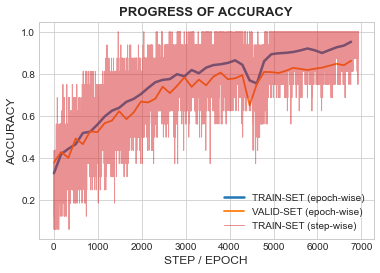

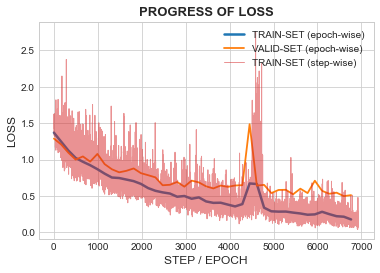



 +++ CONTINGENCY MATRIX +++
[[520. 117.   0.   0.]
 [149. 590.  16.   0.]
 [ 68.  41. 728.   2.]
 [  5.   1.   0. 724.]]


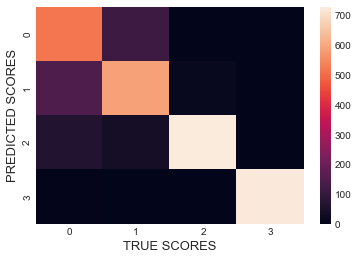


 > LOSS : 0.5878
 > ACCURACY : 0.8652
 > MEAN SQUARED ERR : 0.2182

 > MEAN PRECISION@20 : 42.06 %
 > MEAN RECALL@20 : 93.44 %
 > MEAN R PRECISION : 60.56 %
 > MEAN AVG. PRECISION : 77.31 %

 > MEAN NDCG (@100%) : 0.861801
 > (STD) DEV in NDCG (@100%) : 0.089153

 > MEAN NDCG (@20%) : 0.763172
 > (STD) DEV in NDCG (@20%) : 0.127194


In [39]:
baseline = 'susimcse'
facet = 'result'
Implement(baseline, facet, train=True)


In [40]:
QBERetrieveSciArticles(baseline, facet, '10052042')



 >>> BASELINE : susimcse <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Learning Topic-Sensitive Word Representations
 [ ABSTRACT ] 
 Distributed word representations are widely used for modeling words in NLP tasks.
 Most of the existing models generate one representation per word and do not consider different meanings of a word.
 We present two approaches to learn multiple topic-sensitive representations per word by using Hierarchical Dirichlet Process.
 We observe that by modeling topics and integrating topic distributions for each document we obtain representations that are able to distinguish between different meanings of a given word.
 Our models yield statistically significant improvements for the lexical substitution task indicating that commonly used single word representations, even when combined with contextual information, are insufficient for this task.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 1518169 | GRADED RELEVANCE SCORE : 2.9995
 [ TITLE ] Lea

### [ AGGREGATED ]

In [41]:
baseline = 'susimcse'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 76.298 %
 > (AGG) STD-DEV in NDCG (@100%) : 11.534 %
 > (AGG) MEAN NDCG (@20%) : 58.562 %
 > (AGG) STD-DEV in NDCG (@20%) : 18.585 %
 > (AGG) MEAN PRECISION@20 : 33.30 %
 > (AGG) MEAN RECALL@20 : 77.19 %
 > (AGG) MEAN R PRECISION : 41.84 %
 > (AGG) MEAN AVG. PRECISION : 76.07 %


## UnSimCSE Baseline (unsimcse)

### [ BACKGROUND ]


 > BASELINE : unsimcse
 > FACET : background

 EPOCH   1 | T.LOSS : 1.427827 | T.ACC : 0.262974 | V.LOSS : 1.332624 | V.ACC : 0.312597 | DUR : 1.1092
 EPOCH   2 | T.LOSS : 1.319167 | T.ACC : 0.325948 | V.LOSS : 1.397231 | V.ACC : 0.348367 | DUR : 1.1103
 EPOCH   3 | T.LOSS : 1.198700 | T.ACC : 0.439067 | V.LOSS : 1.190084 | V.ACC : 0.444790 | DUR : 1.1159
 EPOCH   4 | T.LOSS : 1.085915 | T.ACC : 0.482216 | V.LOSS : 1.086227 | V.ACC : 0.461897 | DUR : 1.1166
 EPOCH   5 | T.LOSS : 1.024735 | T.ACC : 0.503790 | V.LOSS : 1.085316 | V.ACC : 0.477449 | DUR : 1.1611
 EPOCH   6 | T.LOSS : 0.932551 | T.ACC : 0.545773 | V.LOSS : 1.188931 | V.ACC : 0.468118 | DUR : 1.0985
 EPOCH   7 | T.LOSS : 0.922241 | T.ACC : 0.564431 | V.LOSS : 1.129183 | V.ACC : 0.480560 | DUR : 1.1131
 EPOCH   8 | T.LOSS : 0.869536 | T.ACC : 0.569096 | V.LOSS : 1.006327 | V.ACC : 0.528771 | DUR : 1.1651
 EPOCH   9 | T.LOSS : 0.851759 | T.ACC : 0.583090 | V.LOSS : 1.036886 | V.ACC : 0.499222 | DUR : 1.1073
 EPOCH  10 | T.LO

 EPOCH  80 | T.LOSS : 0.274708 | T.ACC : 0.903790 | V.LOSS : 1.432876 | V.ACC : 0.673406 | DUR : 1.1331
 EPOCH  81 | T.LOSS : 0.248803 | T.ACC : 0.916618 | V.LOSS : 1.370825 | V.ACC : 0.704510 | DUR : 1.1158
 EPOCH  82 | T.LOSS : 0.210616 | T.ACC : 0.951603 | V.LOSS : 1.275655 | V.ACC : 0.749611 | DUR : 1.1067

 [ EARLY STOPPING : DESIRABLE TRAINING ACCURACY REACHED ! ]

 QBESciAR(
  (fine_tuner): FineTuneNN(
    (dense1): Linear(in_features=768, out_features=768, bias=True)
    (dense2): Linear(in_features=768, out_features=768, bias=True)
  )
  (score_gen): SemRelNN(
    (dense): Linear(in_features=1, out_features=4, bias=True)
    (soft): LogSoftmax(dim=1)
  )
)


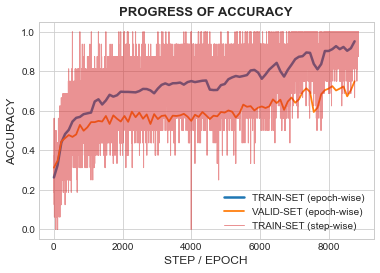

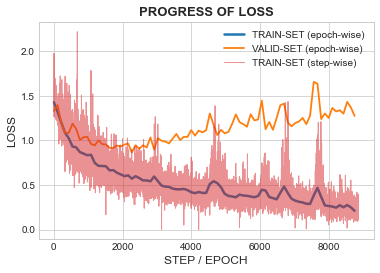



 +++ CONTINGENCY MATRIX +++
[[243.  83.   7.   5.]
 [171. 297.  46.   0.]
 [ 51. 100. 422.   0.]
 [ 27.   4.   0. 474.]]


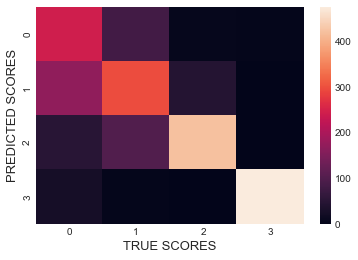


 > LOSS : 1.3729
 > ACCURACY : 0.7440
 > MEAN SQUARED ERR : 0.4850

 > MEAN PRECISION@20 : 40.62 %
 > MEAN RECALL@20 : 66.60 %
 > MEAN R PRECISION : 47.94 %
 > MEAN AVG. PRECISION : 68.56 %

 > MEAN NDCG (@100%) : 0.853754
 > (STD) DEV in NDCG (@100%) : 0.092432

 > MEAN NDCG (@20%) : 0.712786
 > (STD) DEV in NDCG (@20%) : 0.126640


In [42]:
baseline = 'unsimcse'
facet = 'background'
Implement(baseline, facet, train=True)


In [43]:
QBERetrieveSciArticles(baseline, facet, '1791179')



 >>> BASELINE : unsimcse <<<
 >>> FACET : background <<<

 +++ QUERY PAPER +++

 [ TITLE ] A Sequential Model for Multi-Class Classification
 [ ABSTRACT ] 
 Many classification problems require decisions among a large number of competing classes.
 These tasks, however, are not handled well by general purpose learning methods and are usually addressed in an ad-hoc fashion.
 We suggest a general approach -- a sequential learning model that utilizes classifiers to sequentially restrict the number of competing classes while maintaining, with high probability, the presence of the true outcome in the candidates set.
 Some theoretical and computational properties of the model are discussed and we argue that these are important in NLP-like domains.
 The advantages of the model are illustrated in an experiment in part-of-speech tagging.

 +++ TOP 15 PAPERS +++

 RANK : 1 | PAPER I.D. : 63643710 | GRADED RELEVANCE SCORE : 2.9967
 [ TITLE ] Multiclass Classification Through Multidimensional Clus

### [ METHOD ]


 > BASELINE : unsimcse
 > FACET : method

 EPOCH   1 | T.LOSS : 1.472361 | T.ACC : 0.289747 | V.LOSS : 1.447888 | V.ACC : 0.282458 | DUR : 1.8134
 EPOCH   2 | T.LOSS : 1.273865 | T.ACC : 0.378900 | V.LOSS : 1.214819 | V.ACC : 0.430129 | DUR : 1.7791
 EPOCH   3 | T.LOSS : 1.047924 | T.ACC : 0.518574 | V.LOSS : 0.958018 | V.ACC : 0.532210 | DUR : 1.7243
 EPOCH   4 | T.LOSS : 0.947297 | T.ACC : 0.549034 | V.LOSS : 0.924781 | V.ACC : 0.562934 | DUR : 1.8146
 EPOCH   5 | T.LOSS : 0.901673 | T.ACC : 0.568351 | V.LOSS : 0.893283 | V.ACC : 0.583746 | DUR : 1.8885
 EPOCH   6 | T.LOSS : 0.839700 | T.ACC : 0.596954 | V.LOSS : 0.911136 | V.ACC : 0.589693 | DUR : 1.8470
 EPOCH   7 | T.LOSS : 0.801329 | T.ACC : 0.609584 | V.LOSS : 0.849147 | V.ACC : 0.607532 | DUR : 1.8648
 EPOCH   8 | T.LOSS : 0.778134 | T.ACC : 0.629643 | V.LOSS : 0.852644 | V.ACC : 0.608523 | DUR : 1.8095
 EPOCH   9 | T.LOSS : 0.790340 | T.ACC : 0.629272 | V.LOSS : 0.805940 | V.ACC : 0.601586 | DUR : 1.7803
 EPOCH  10 | T.LOSS :

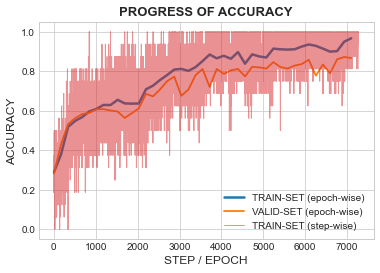

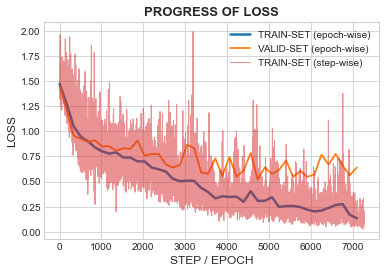



 +++ CONTINGENCY MATRIX +++
[[464. 109.   0.   0.]
 [214. 585.   7.   0.]
 [ 78.  54. 752.   0.]
 [  3.   0.   0. 765.]]


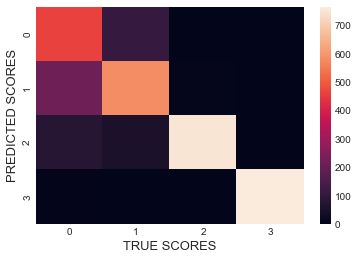


 > LOSS : 0.6513
 > ACCURACY : 0.8466
 > MEAN SQUARED ERR : 0.2385

 > MEAN PRECISION@20 : 29.41 %
 > MEAN RECALL@20 : 91.32 %
 > MEAN R PRECISION : 42.54 %
 > MEAN AVG. PRECISION : 77.39 %

 > MEAN NDCG (@100%) : 0.798857
 > (STD) DEV in NDCG (@100%) : 0.082546

 > MEAN NDCG (@20%) : 0.650750
 > (STD) DEV in NDCG (@20%) : 0.116222


In [44]:
baseline = 'unsimcse'
facet = 'method'
Implement(baseline, facet, train=True)


In [45]:
QBERetrieveSciArticles(baseline, facet, '1198964')



 >>> BASELINE : unsimcse <<<
 >>> FACET : method <<<

 +++ QUERY PAPER +++

 [ TITLE ] Edge-Linear First-Order Dependency Parsing with Undirected Minimum Spanning Tree Inference
 [ ABSTRACT ] 
 The run time complexity of state-of-the-art inference algorithms in graph-based dependency parsing is super-linear in the number of input words (n).
 Recently, pruning algorithms for these models have shown to cut a large portion of the graph edges, with minimal damage to the resulting parse trees.
 Solving the inference problem in run time complexity determined solely by the number of edges (m) is hence of obvious importance.
 We propose such an inference algorithm for first-order models, which encodes the problem as a minimum spanning tree (MST) problem in an undirected graph.
 This allows us to utilize state-of-the-art undirected MST algorithms whose run time is O(m) at expectation and with a very high probability.
 A directed parse tree is then inferred from the undirected MST and is subseq

### [ RESULTS ]


 > BASELINE : unsimcse
 > FACET : result

 EPOCH   1 | T.LOSS : 1.201080 | T.ACC : 0.426292 | V.LOSS : 0.969931 | V.ACC : 0.484296 | DUR : 1.6841
 EPOCH   2 | T.LOSS : 0.985256 | T.ACC : 0.484423 | V.LOSS : 0.896694 | V.ACC : 0.493414 | DUR : 1.6878
 EPOCH   3 | T.LOSS : 0.877964 | T.ACC : 0.507599 | V.LOSS : 0.872166 | V.ACC : 0.499493 | DUR : 1.7057
 EPOCH   4 | T.LOSS : 0.880439 | T.ACC : 0.516717 | V.LOSS : 0.851289 | V.ACC : 0.510638 | DUR : 1.6937
 EPOCH   5 | T.LOSS : 0.853479 | T.ACC : 0.513678 | V.LOSS : 0.873872 | V.ACC : 0.506586 | DUR : 1.6832
 EPOCH   6 | T.LOSS : 0.846348 | T.ACC : 0.531535 | V.LOSS : 0.910404 | V.ACC : 0.488349 | DUR : 1.6836
 EPOCH   7 | T.LOSS : 0.877276 | T.ACC : 0.519377 | V.LOSS : 0.868913 | V.ACC : 0.525836 | DUR : 1.6854
 EPOCH   8 | T.LOSS : 0.880998 | T.ACC : 0.514438 | V.LOSS : 0.829403 | V.ACC : 0.530902 | DUR : 1.6848
 EPOCH   9 | T.LOSS : 0.812454 | T.ACC : 0.548632 | V.LOSS : 0.845380 | V.ACC : 0.534954 | DUR : 1.6836
 EPOCH  10 | T.LOSS :

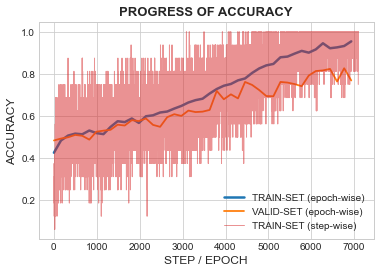

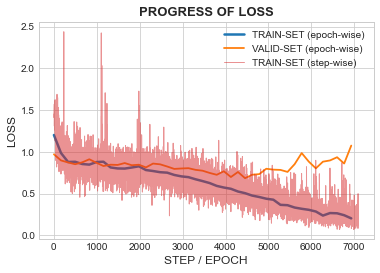



 +++ CONTINGENCY MATRIX +++
[[407. 130.   3.   1.]
 [186. 459.  55.   0.]
 [ 69. 135. 739.   0.]
 [ 30.   3.   0. 744.]]


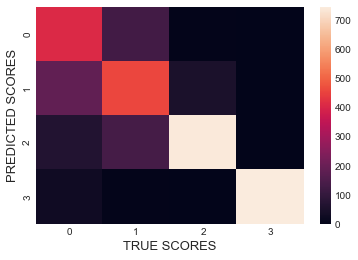


 > LOSS : 0.9221
 > ACCURACY : 0.7933
 > MEAN SQUARED ERR : 0.3664

 > MEAN PRECISION@20 : 36.18 %
 > MEAN RECALL@20 : 83.05 %
 > MEAN R PRECISION : 37.82 %
 > MEAN AVG. PRECISION : 77.29 %

 > MEAN NDCG (@100%) : 0.726253
 > (STD) DEV in NDCG (@100%) : 0.113895

 > MEAN NDCG (@20%) : 0.575986
 > (STD) DEV in NDCG (@20%) : 0.147306


In [46]:
baseline = 'unsimcse'
facet = 'result'
Implement(baseline, facet, train=True)


In [47]:
QBERetrieveSciArticles(baseline, facet, '5052952')



 >>> BASELINE : unsimcse <<<
 >>> FACET : result <<<

 +++ QUERY PAPER +++

 [ TITLE ] Veracity Computing from Lexical Cues and Perceived Certainty Trends
 [ ABSTRACT ] 
 We present a data-driven method for determining the veracity of a set of rumorous claims on social media data.
 Tweets from different sources pertaining to a rumor are processed on three levels: first, factuality values are assigned to each tweet based on four textual cue categories relevant for our journalism use case; these amalgamate speaker support in terms of polarity and commitment in terms of certainty and speculation.
 Next, the proportions of these lexical cues are utilized as predictors for tweet certainty in a generalized linear regression model.
 Subsequently, lexical cue proportions, predicted certainty, as well as their time course characteristics are used to compute veracity for each rumor in terms of the identity of the rumor-resolving tweet and its binary resolution value judgment.
 The system operat

### [ AGGREGATED ]

In [48]:
baseline = 'unsimcse'
EvaluateOnAllQueries(baseline)


 > (AGG) MEAN NDCG (@100%) : 79.174 %
 > (AGG) STD-DEV in NDCG (@100%) : 11.030 %
 > (AGG) MEAN NDCG (@20%) : 64.518 %
 > (AGG) STD-DEV in NDCG (@20%) : 14.214 %
 > (AGG) MEAN PRECISION@20 : 35.30 %
 > (AGG) MEAN RECALL@20 : 80.60 %
 > (AGG) MEAN R PRECISION : 42.67 %
 > (AGG) MEAN AVG. PRECISION : 74.53 %


## ENSEMBLE CONSTRUCTION

###### The following table contains the %-NDCG values (for 100% data, unless explicitly mentioned otherwise) for all baseline-facet pairs and also for the aggregated pool of queries.

| <i>FACET / BASELINE</i> | BERT_NLI | BERT_PP | SCIBERT_CASED | SCIBERT_UNCASED | SPECTER | SUSIMCSE | UNSIMCSE |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| <b>BACKGROUND</b> | 82.385 | 81.068 | 91.348 | 87.135 | 84.368 | 72.703 | 85.375 |
| <b>METHOD</b> | 74.207 | 75.903 | 82.514 | 66.224 | 64.892 | 69.798 | 79.886 |
| <b>RESULTS</b> | 70.108 | 76.722 | 78.518 | 82.680 | 89.445 | 86.180 | 72.625 |
| <b>AGG@100%</b> | 75.431 | 77.834 | 83.982 | 78.510 | 79.473 | 76.298 | 79.174 |
| <b>AGG@20%</b> | 58.789 | 61.789 | 69.356 | 62.647 | 64.451 | 58.562 | 64.518 |

In [49]:
EnsembleEvaluateOnAllQueries(['scibert_cased', 'specter', 'scibert_cased'])


 > (AGG) MEAN NDCG (@100%) : 87.70 %
 > (AGG) STD-DEV in NDCG (@100%) : 7.95 %
 > (AGG) MEAN NDCG (@20%) : 76.20 %
 > (AGG) STD-DEV in NDCG (@20%) : 13.31 %
 > (AGG) MEAN PRECISION@20 : 39.20 %
 > (AGG) MEAN RECALL@20 : 80.68 %
 > (AGG) MEAN R PRECISION : 63.78 %
 > (AGG) MEAN AVG. PRECISION : 73.78 %
